# Expert Analysis Notebook

This notebook contains the experiments and plots used in the ``Technical Validation'' Section in the main paper

In [75]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import pickle
import yaml
import os
import scipy
os.makedirs('./Images/', exist_ok = True)

### Feature Dependence and Algorithmic Bias

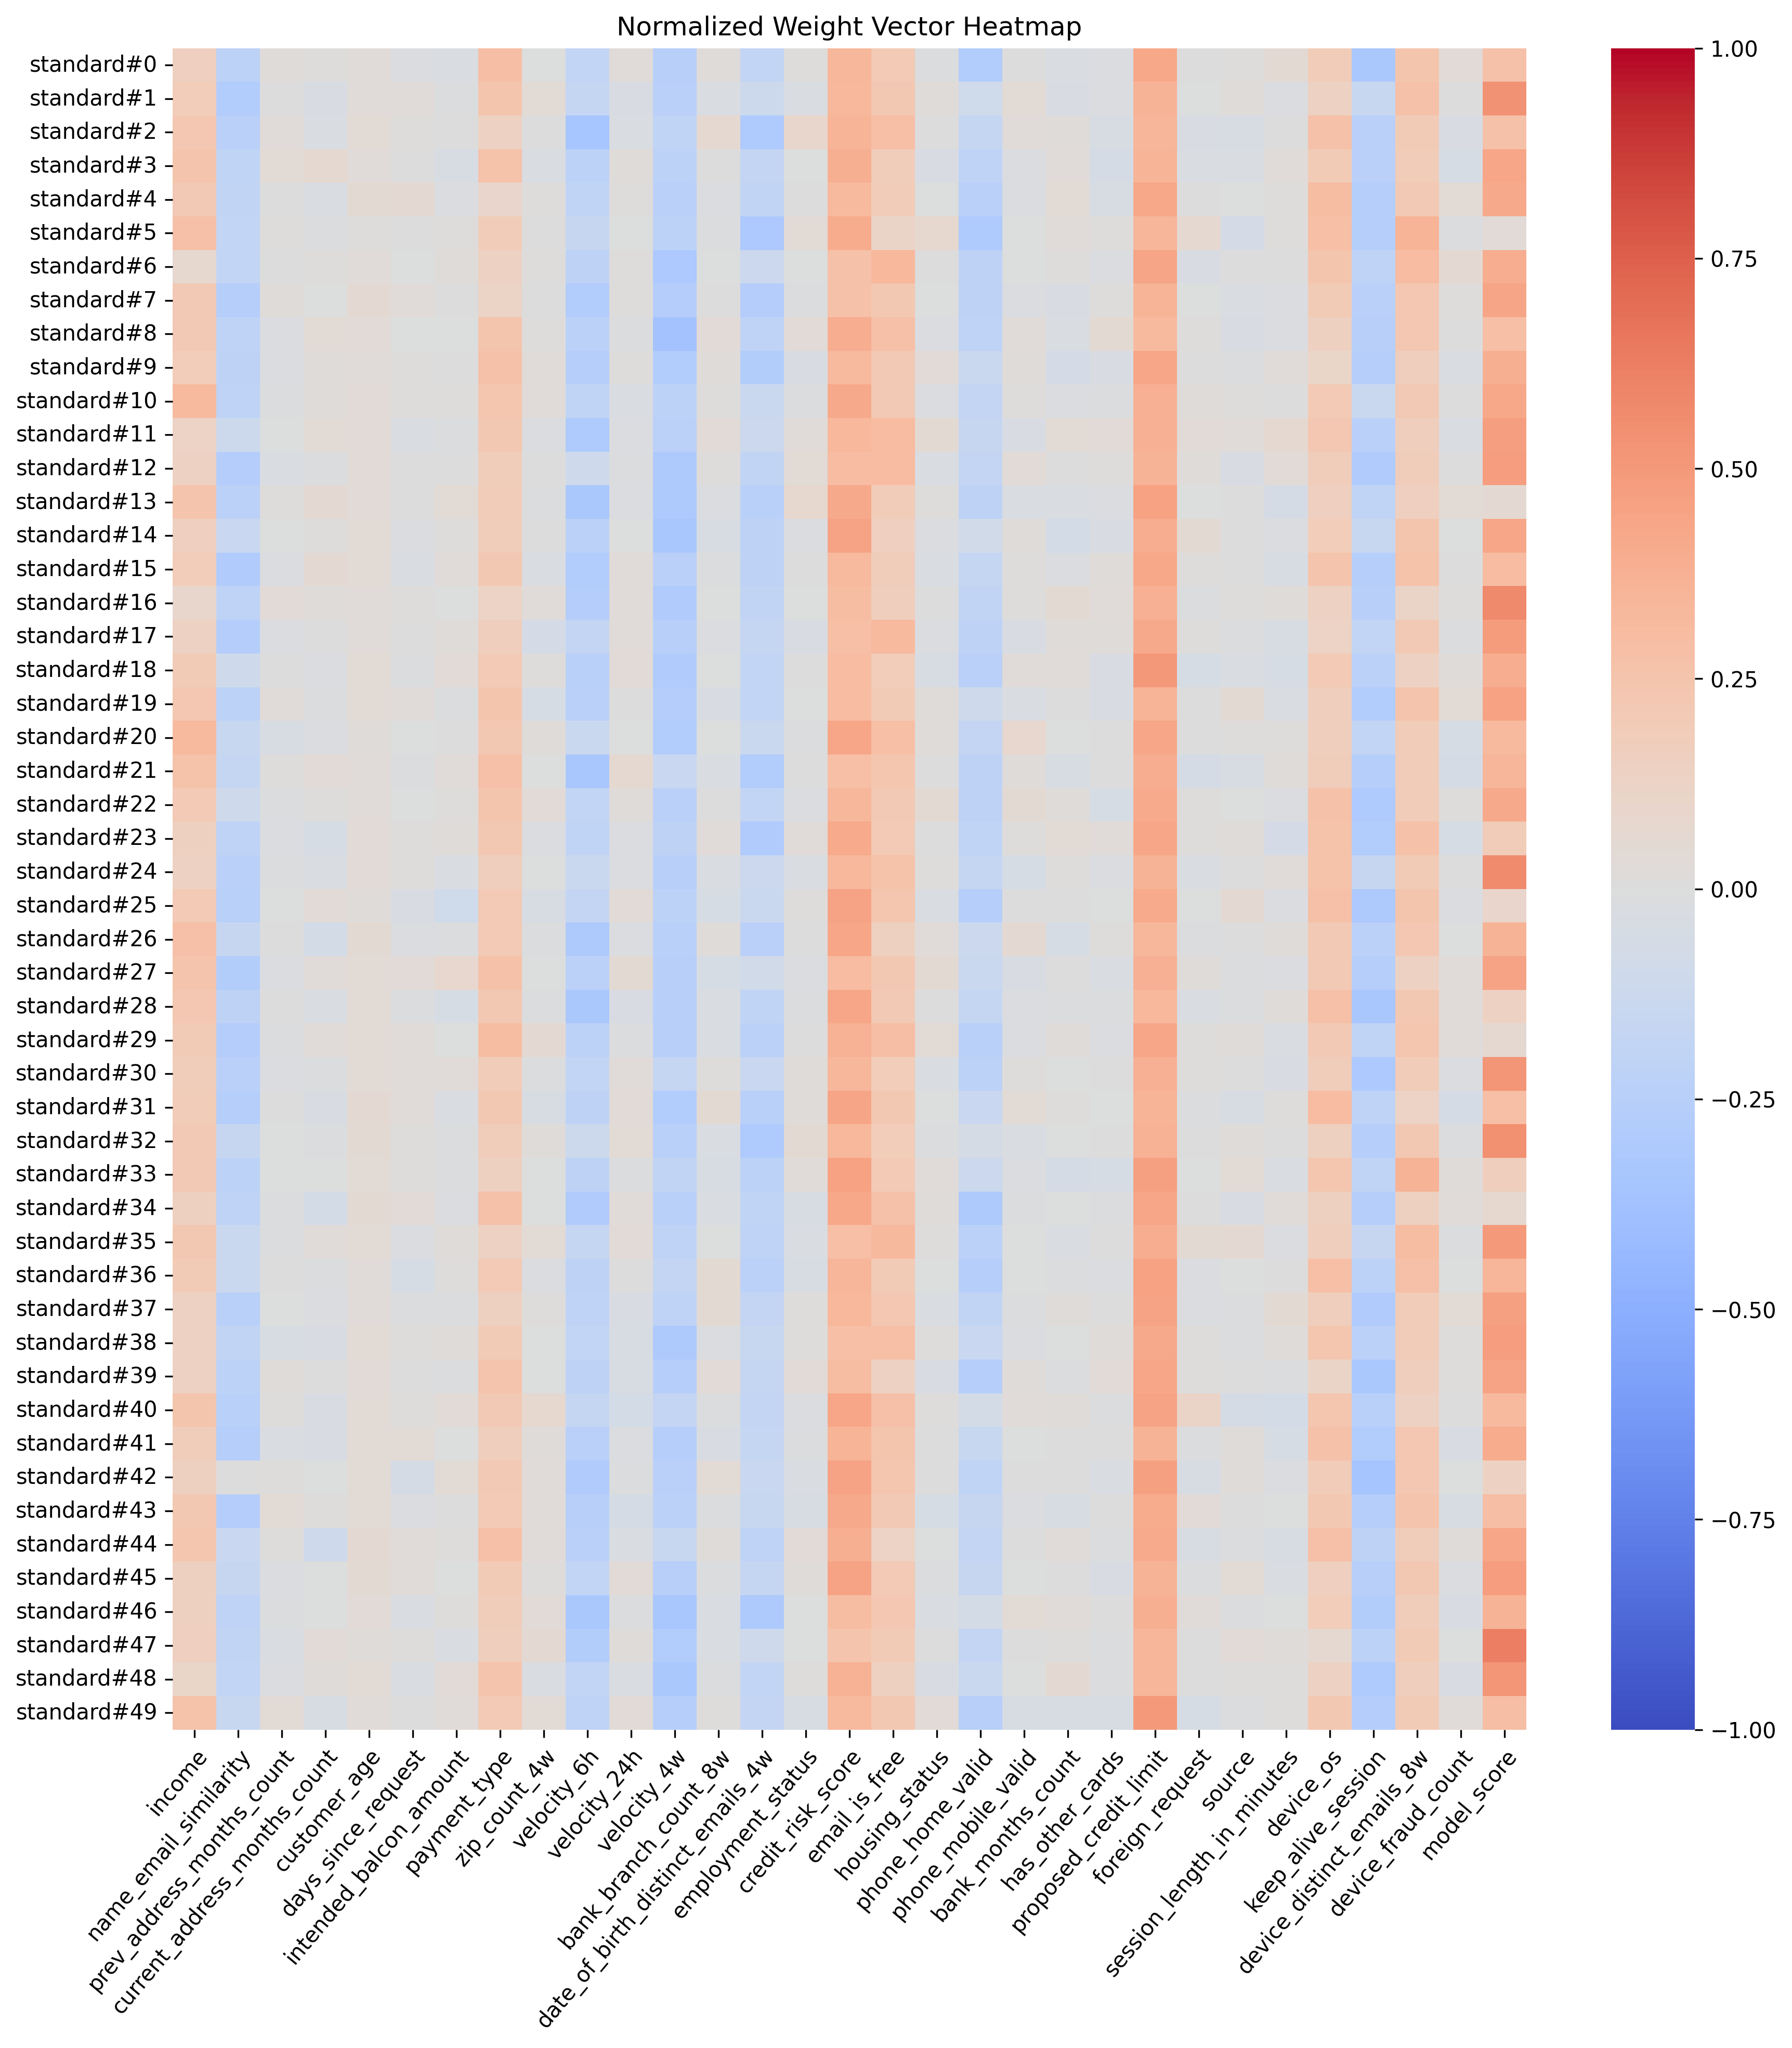

In [76]:
prop = pd.read_parquet(f'../../FiFAR/synthetic_experts/expert_parameters.parquet')
w = prop.drop(columns =['fp_beta', 'fn_beta', 'alpha'])
w = w.div(np.sqrt(np.square(w).sum(axis=1)), axis = 0)

f, ax = plt.subplots(figsize=(14, 14), dpi = 300)
sns.heatmap(w, robust=True, cmap = 'coolwarm', vmax = 1, vmin = -1, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title("Normalized Weight Vector Heatmap")
plt.xticks(rotation = 50, rotation_mode = 'anchor', ha = 'right')
plt.savefig("./Images/w_heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [77]:
data_cfg_path = '../alert_data/dataset_cfg.yaml'

with open(data_cfg_path, 'r') as infile:
    data_cfg = yaml.safe_load(infile)

data = pd.read_parquet(f'../../FiFAR/alert_data/processed_data/alerts.parquet')
preds = pd.read_parquet(f'../../FiFAR/synthetic_experts/expert_predictions.parquet').loc[data.index]

CATEGORICAL_COLS = data_cfg['data_cols']['categorical']

train = data.loc[(data["month"] > 2) & (data["month"] < 6)]
val = data.loc[data["month"] == 6]
test = data.loc[data["month"] == 7]

X_train = train.drop(columns = ['fraud_bool','month']).sample(6000, random_state = 42)
X_val = val.drop(columns = ['fraud_bool','month']).sample(2000, random_state = 42)
X_test = test.drop(columns = ['fraud_bool','month']).sample(2000, random_state = 42)

roc_curves_val = dict()
roc_curves_test = dict()
roc_auc = dict()
best_thresh = dict()

for expert in preds.columns:
    y_val = preds.loc[X_val.index,expert]

    roc_curves_val[expert] = dict()
    roc_curves_test[expert] = dict()

    with open(f'../../l2d_benchmarking/feature_dependence_models/{expert}/best_model.pickle', 'rb') as infile:
        model = pickle.load(infile)

    y_test = preds.loc[X_test.index,expert]
    y_pred = model.predict_proba(X_test)
    y_pred = y_pred[:,1]

    roc_curves_test[expert]['fpr'],roc_curves_test[expert]['tpr'],roc_curves_test[expert]['thr'] = roc_curve(y_test, y_pred)
    roc_auc[expert] = roc_auc_score(y_test, y_pred)

    y_pred = model.predict_proba(X_val)

    y_pred = y_pred[:,1]

    roc_curves_val[expert]['fpr'],roc_curves_val[expert]['tpr'],roc_curves_val[expert]['thr'] = roc_curve(y_val, y_pred)

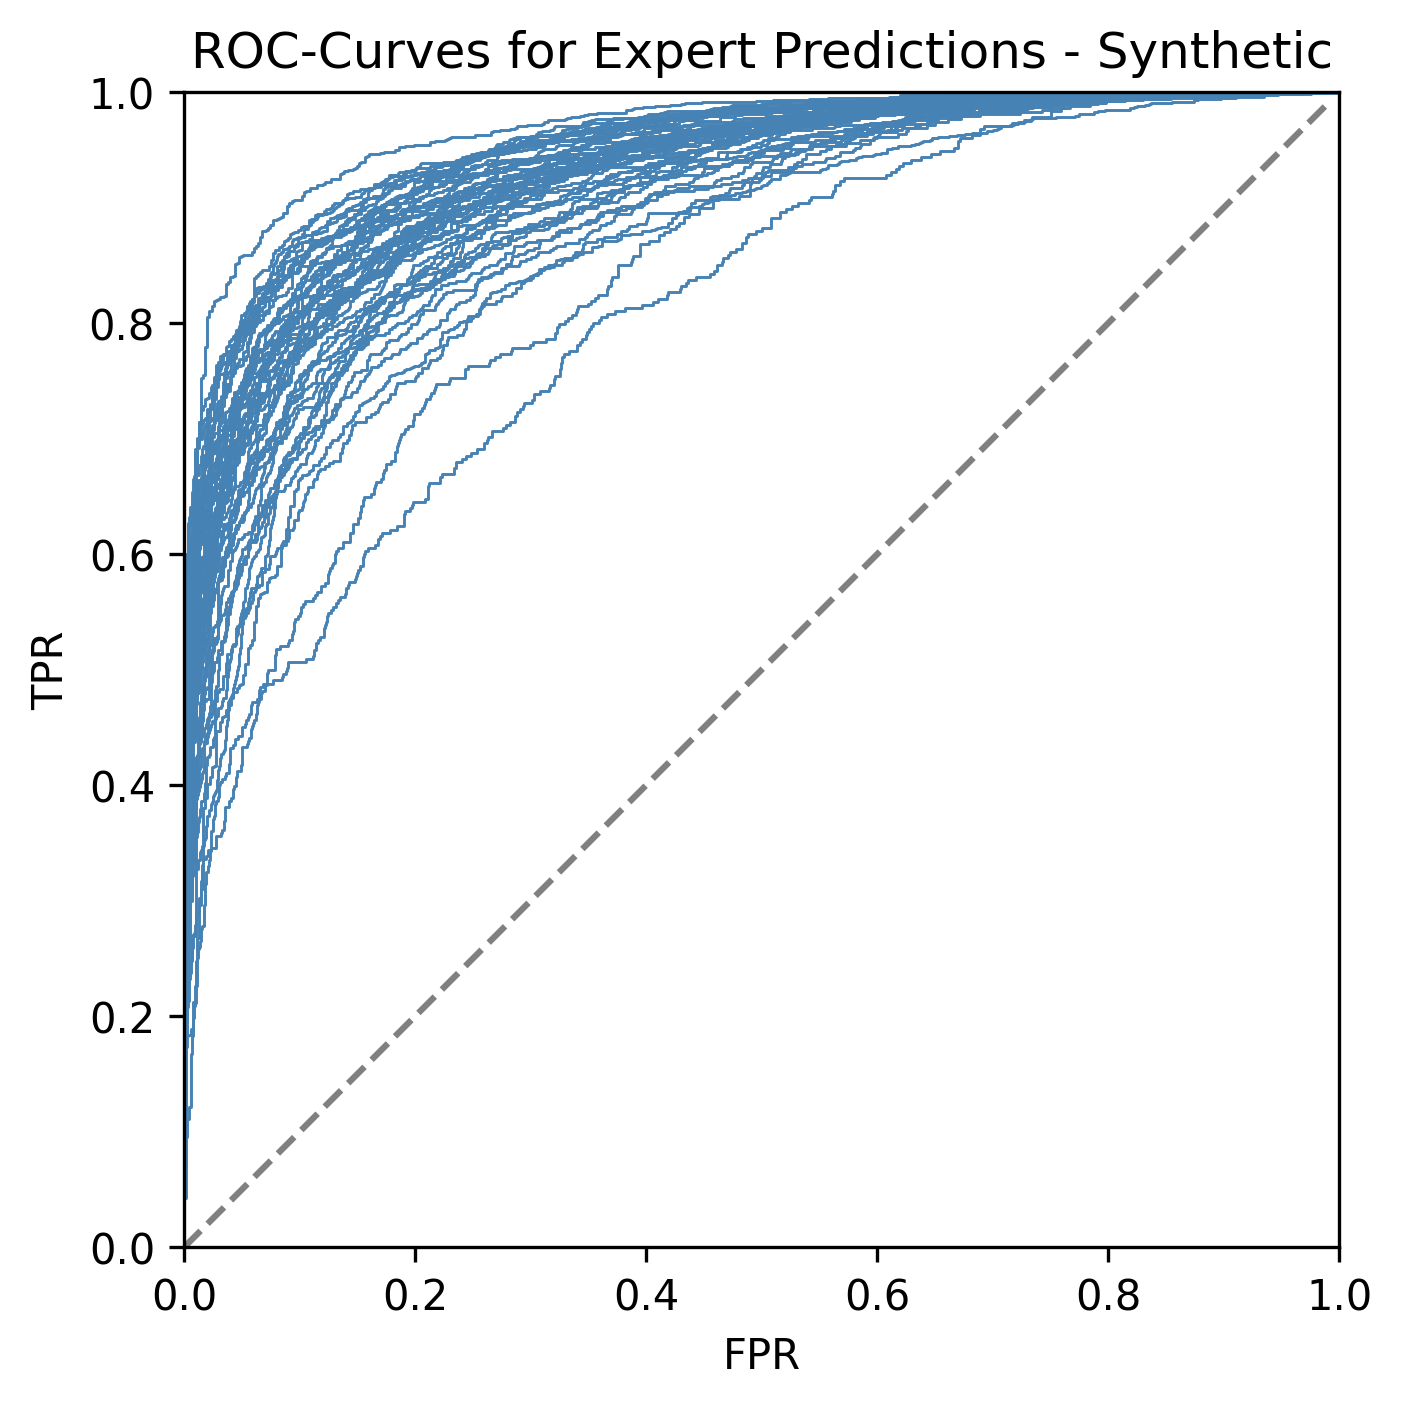

In [78]:
f, ax = plt.subplots(figsize=(5, 5), dpi = 300)
plt.gca().set_aspect('equal')
for expert in preds.columns:
    plt.plot(roc_curves_test[expert]['fpr'], roc_curves_test[expert]['tpr'], linewidth = 0.7, c = 'steelblue')
plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC-Curves for Expert Predictions - Synthetic')
plt.savefig("./Images/figure_12_b.pdf", format="pdf", bbox_inches="tight")
plt.show()

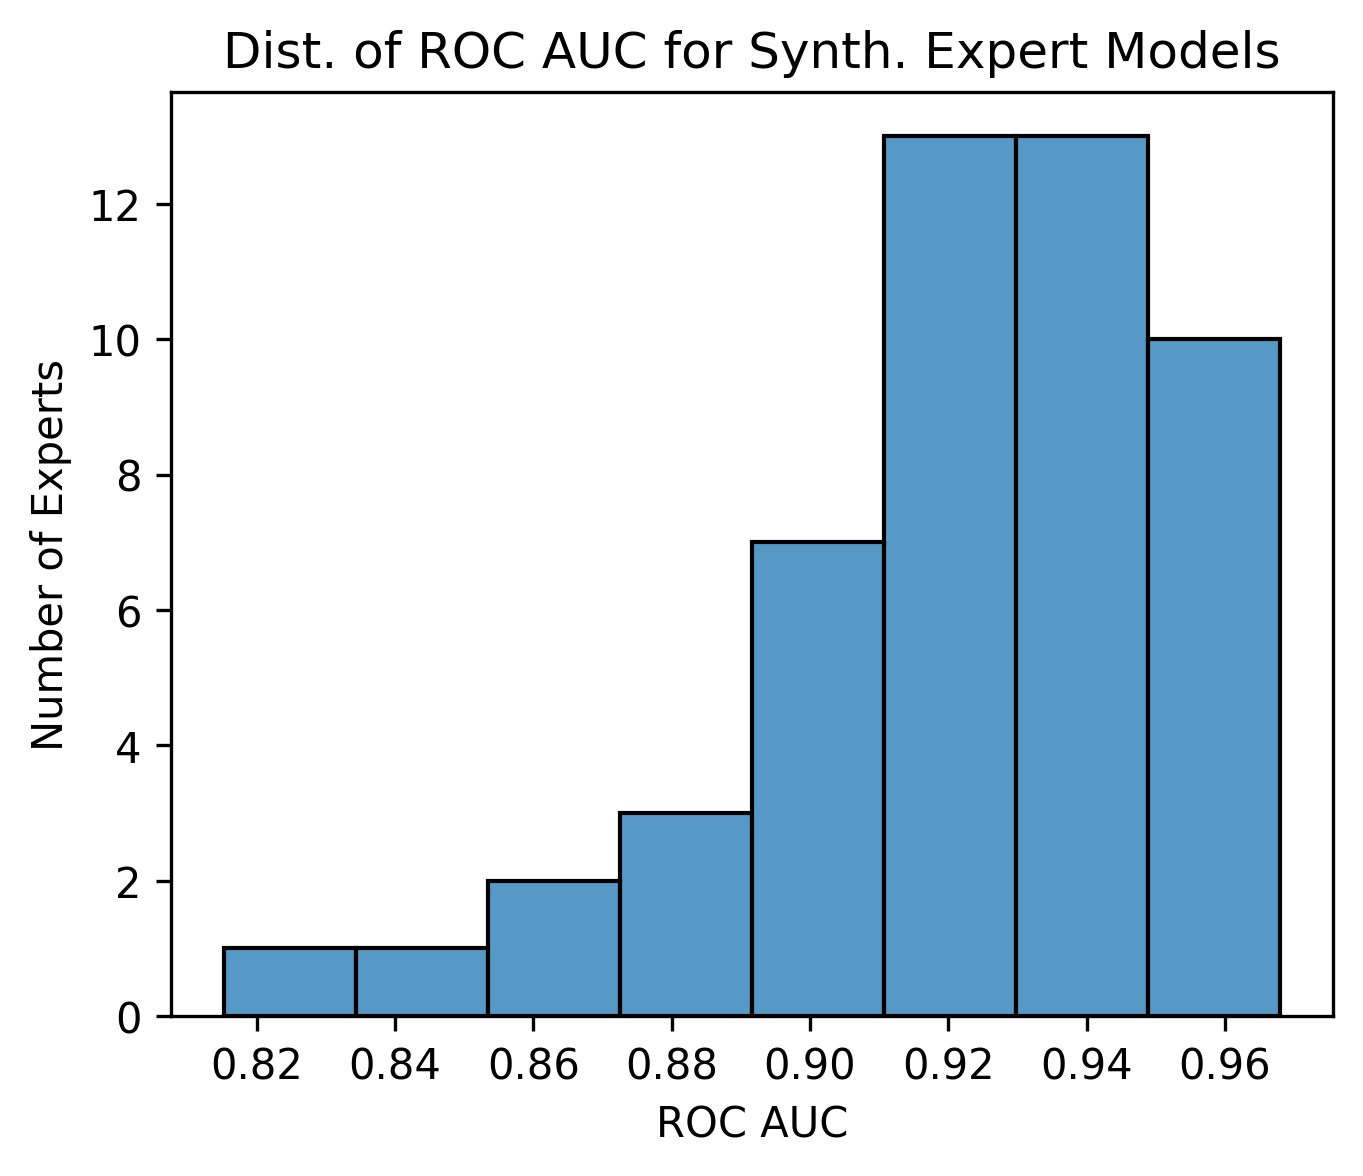

In [79]:
f, ax = plt.subplots(figsize=(5, 4), dpi = 300)
sns.histplot(x = roc_auc.values())
plt.xlabel(r"ROC AUC")
plt.ylabel("Number of Experts")
plt.title(r"Dist. of ROC AUC for Synth. Expert Models")
plt.savefig("./Images/figure_13_b.pdf", format="pdf", bbox_inches="tight")

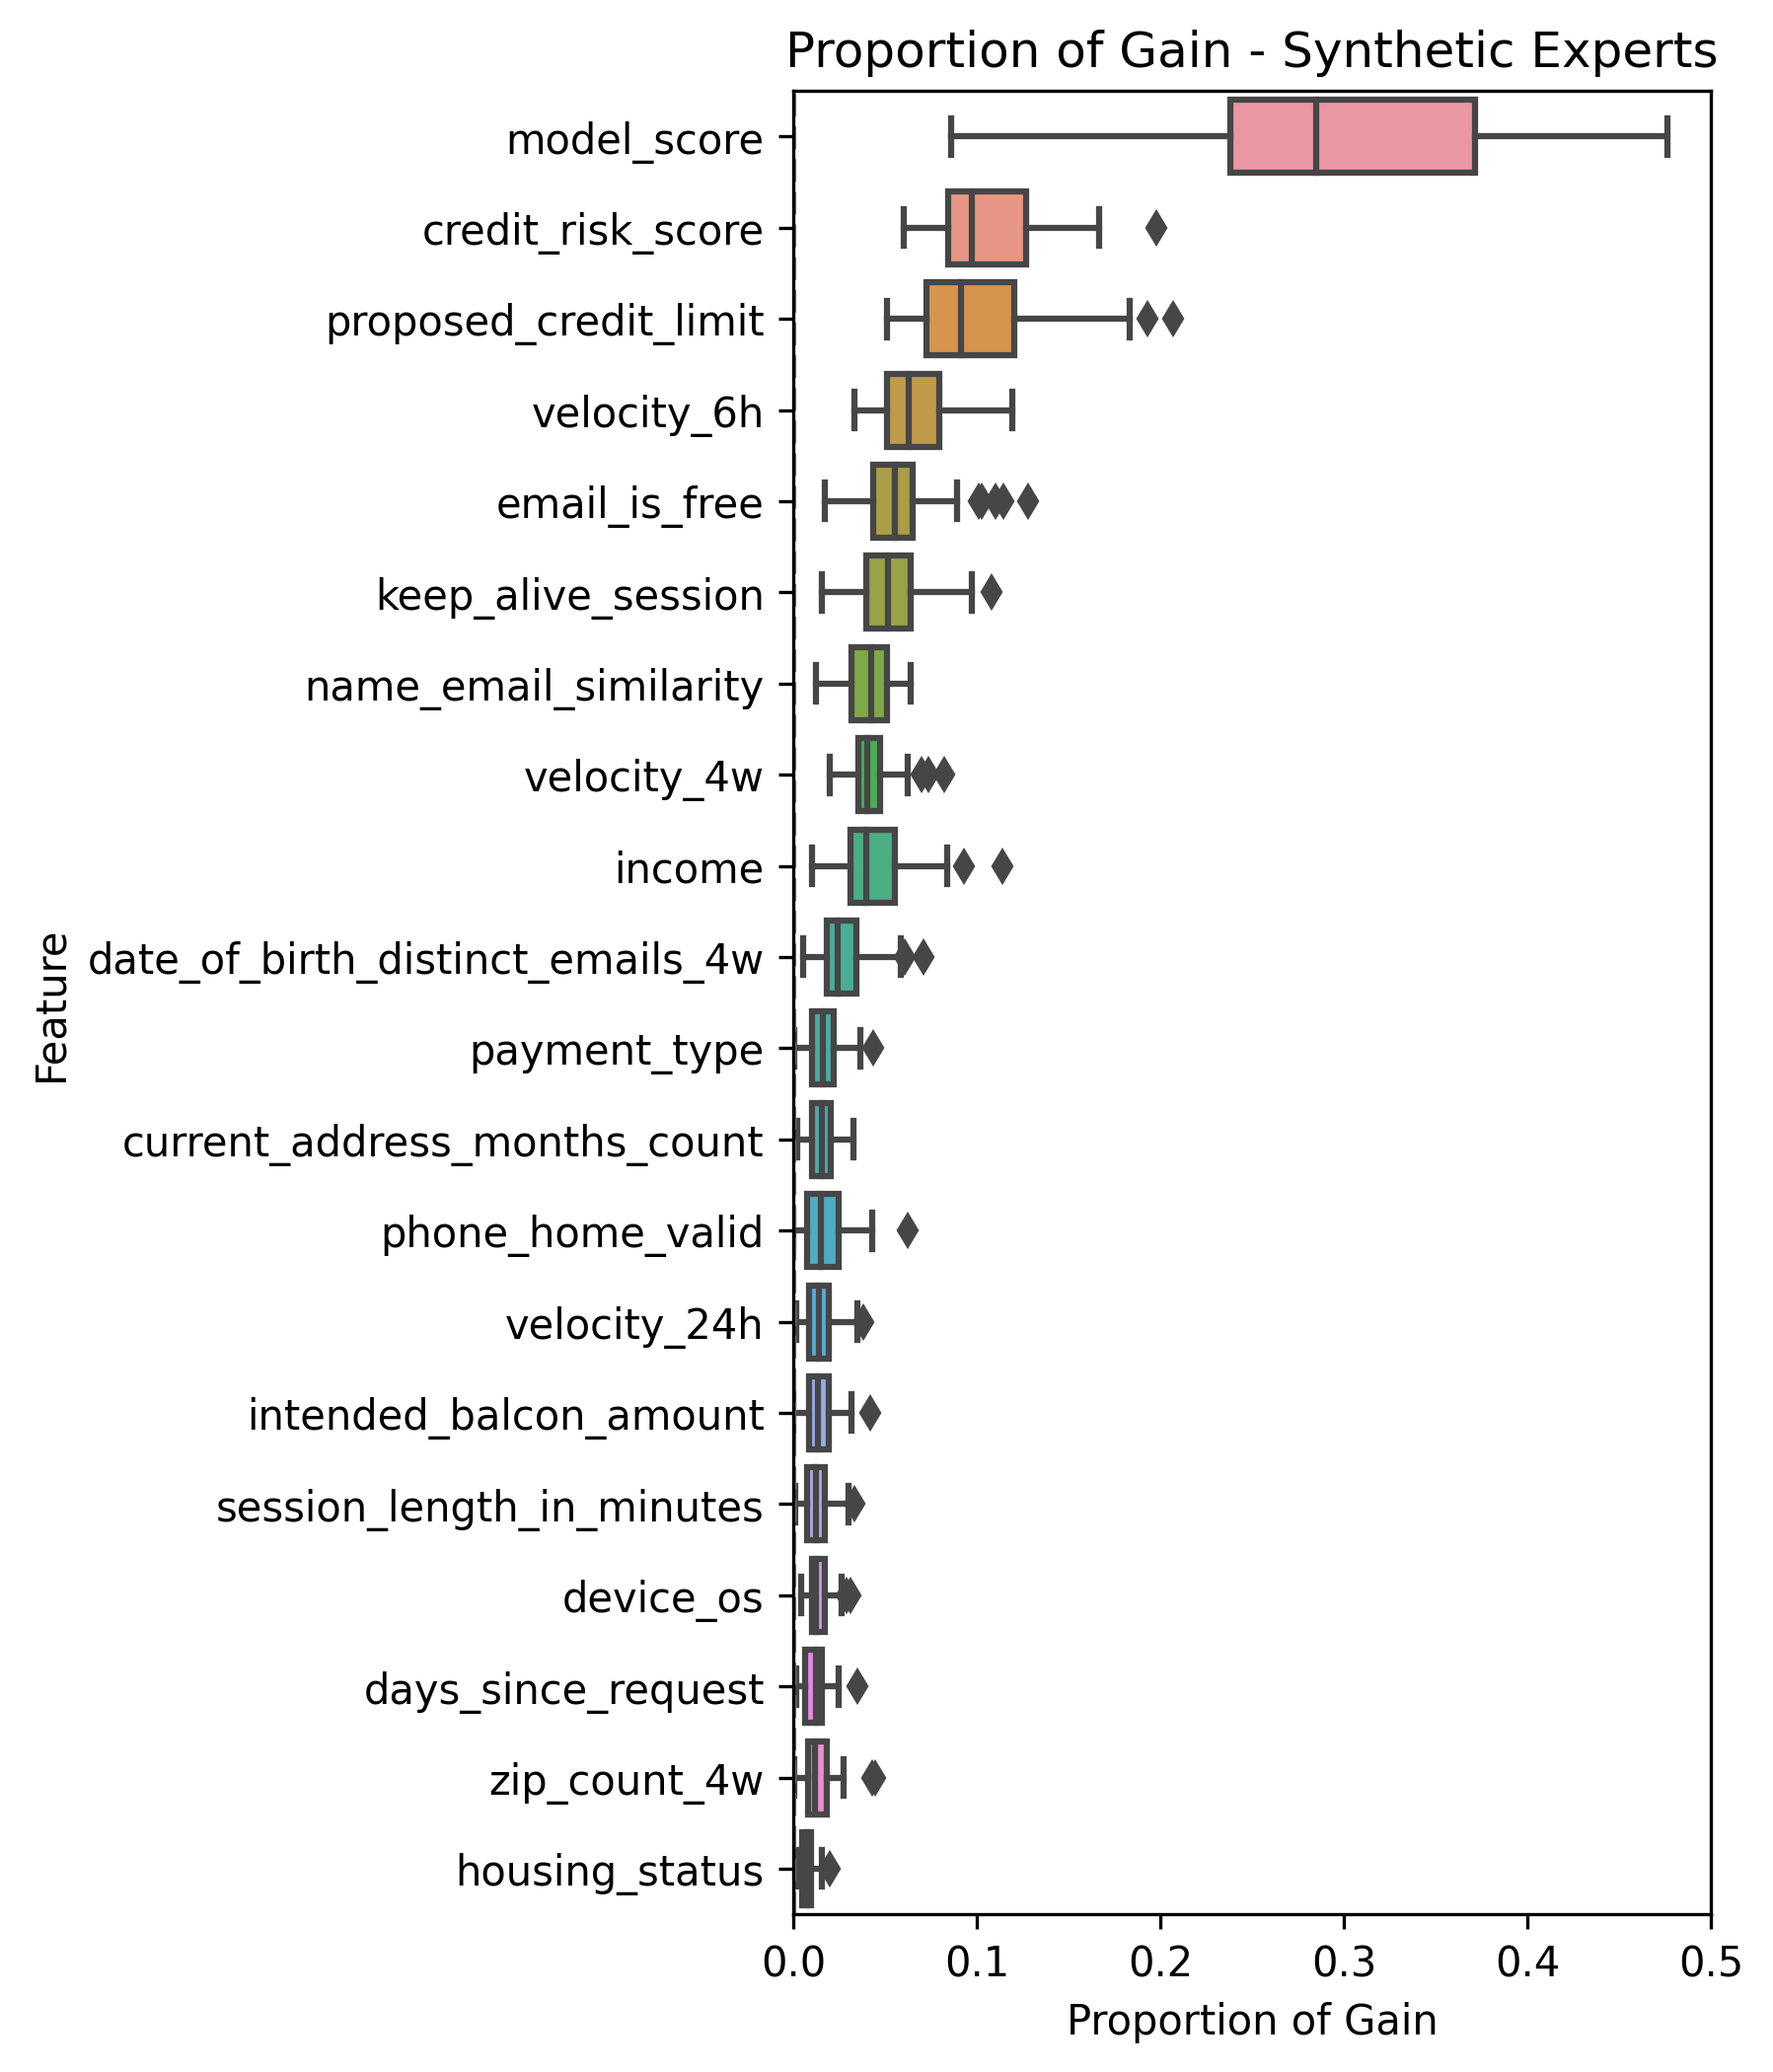

In [80]:
feature_imps = pd.DataFrame(index = preds.columns, columns = model.feature_name_)

for expert in preds.columns:
    with open(f'../../l2d_benchmarking/feature_dependence_models/{expert}/best_model.pickle', 'rb') as infile:
        model = pickle.load(infile)
        feature_imps.loc[expert,:] = model.booster_.feature_importance(importance_type = 'gain')

n_feat = 20
a = feature_imps.T
a.loc['sum'] = a.sum(axis = 0)
a = a.div(a.iloc[-1])
a = a.drop('sum')
a['median'] = a.median(axis = 1)
a = a.sort_values(by = 'median', ascending = False).drop(columns = 'median')
a = a.iloc[0:n_feat]
a = a.T


f, ax = plt.subplots(figsize=(4, 8), dpi = 300)
sns.boxplot(data=a.melt(), x='value', y = 'variable')
plt.axvline(x = 0,  ls = '--', color = 'gray')
plt.xlabel('Proportion of Gain')
plt.ylabel('Feature')
plt.title('Proportion of Gain - Synthetic Experts')
plt.xlim([0,0.5])
plt.savefig("./Images/figure_14_b.pdf", format="pdf", bbox_inches="tight")
plt.show()

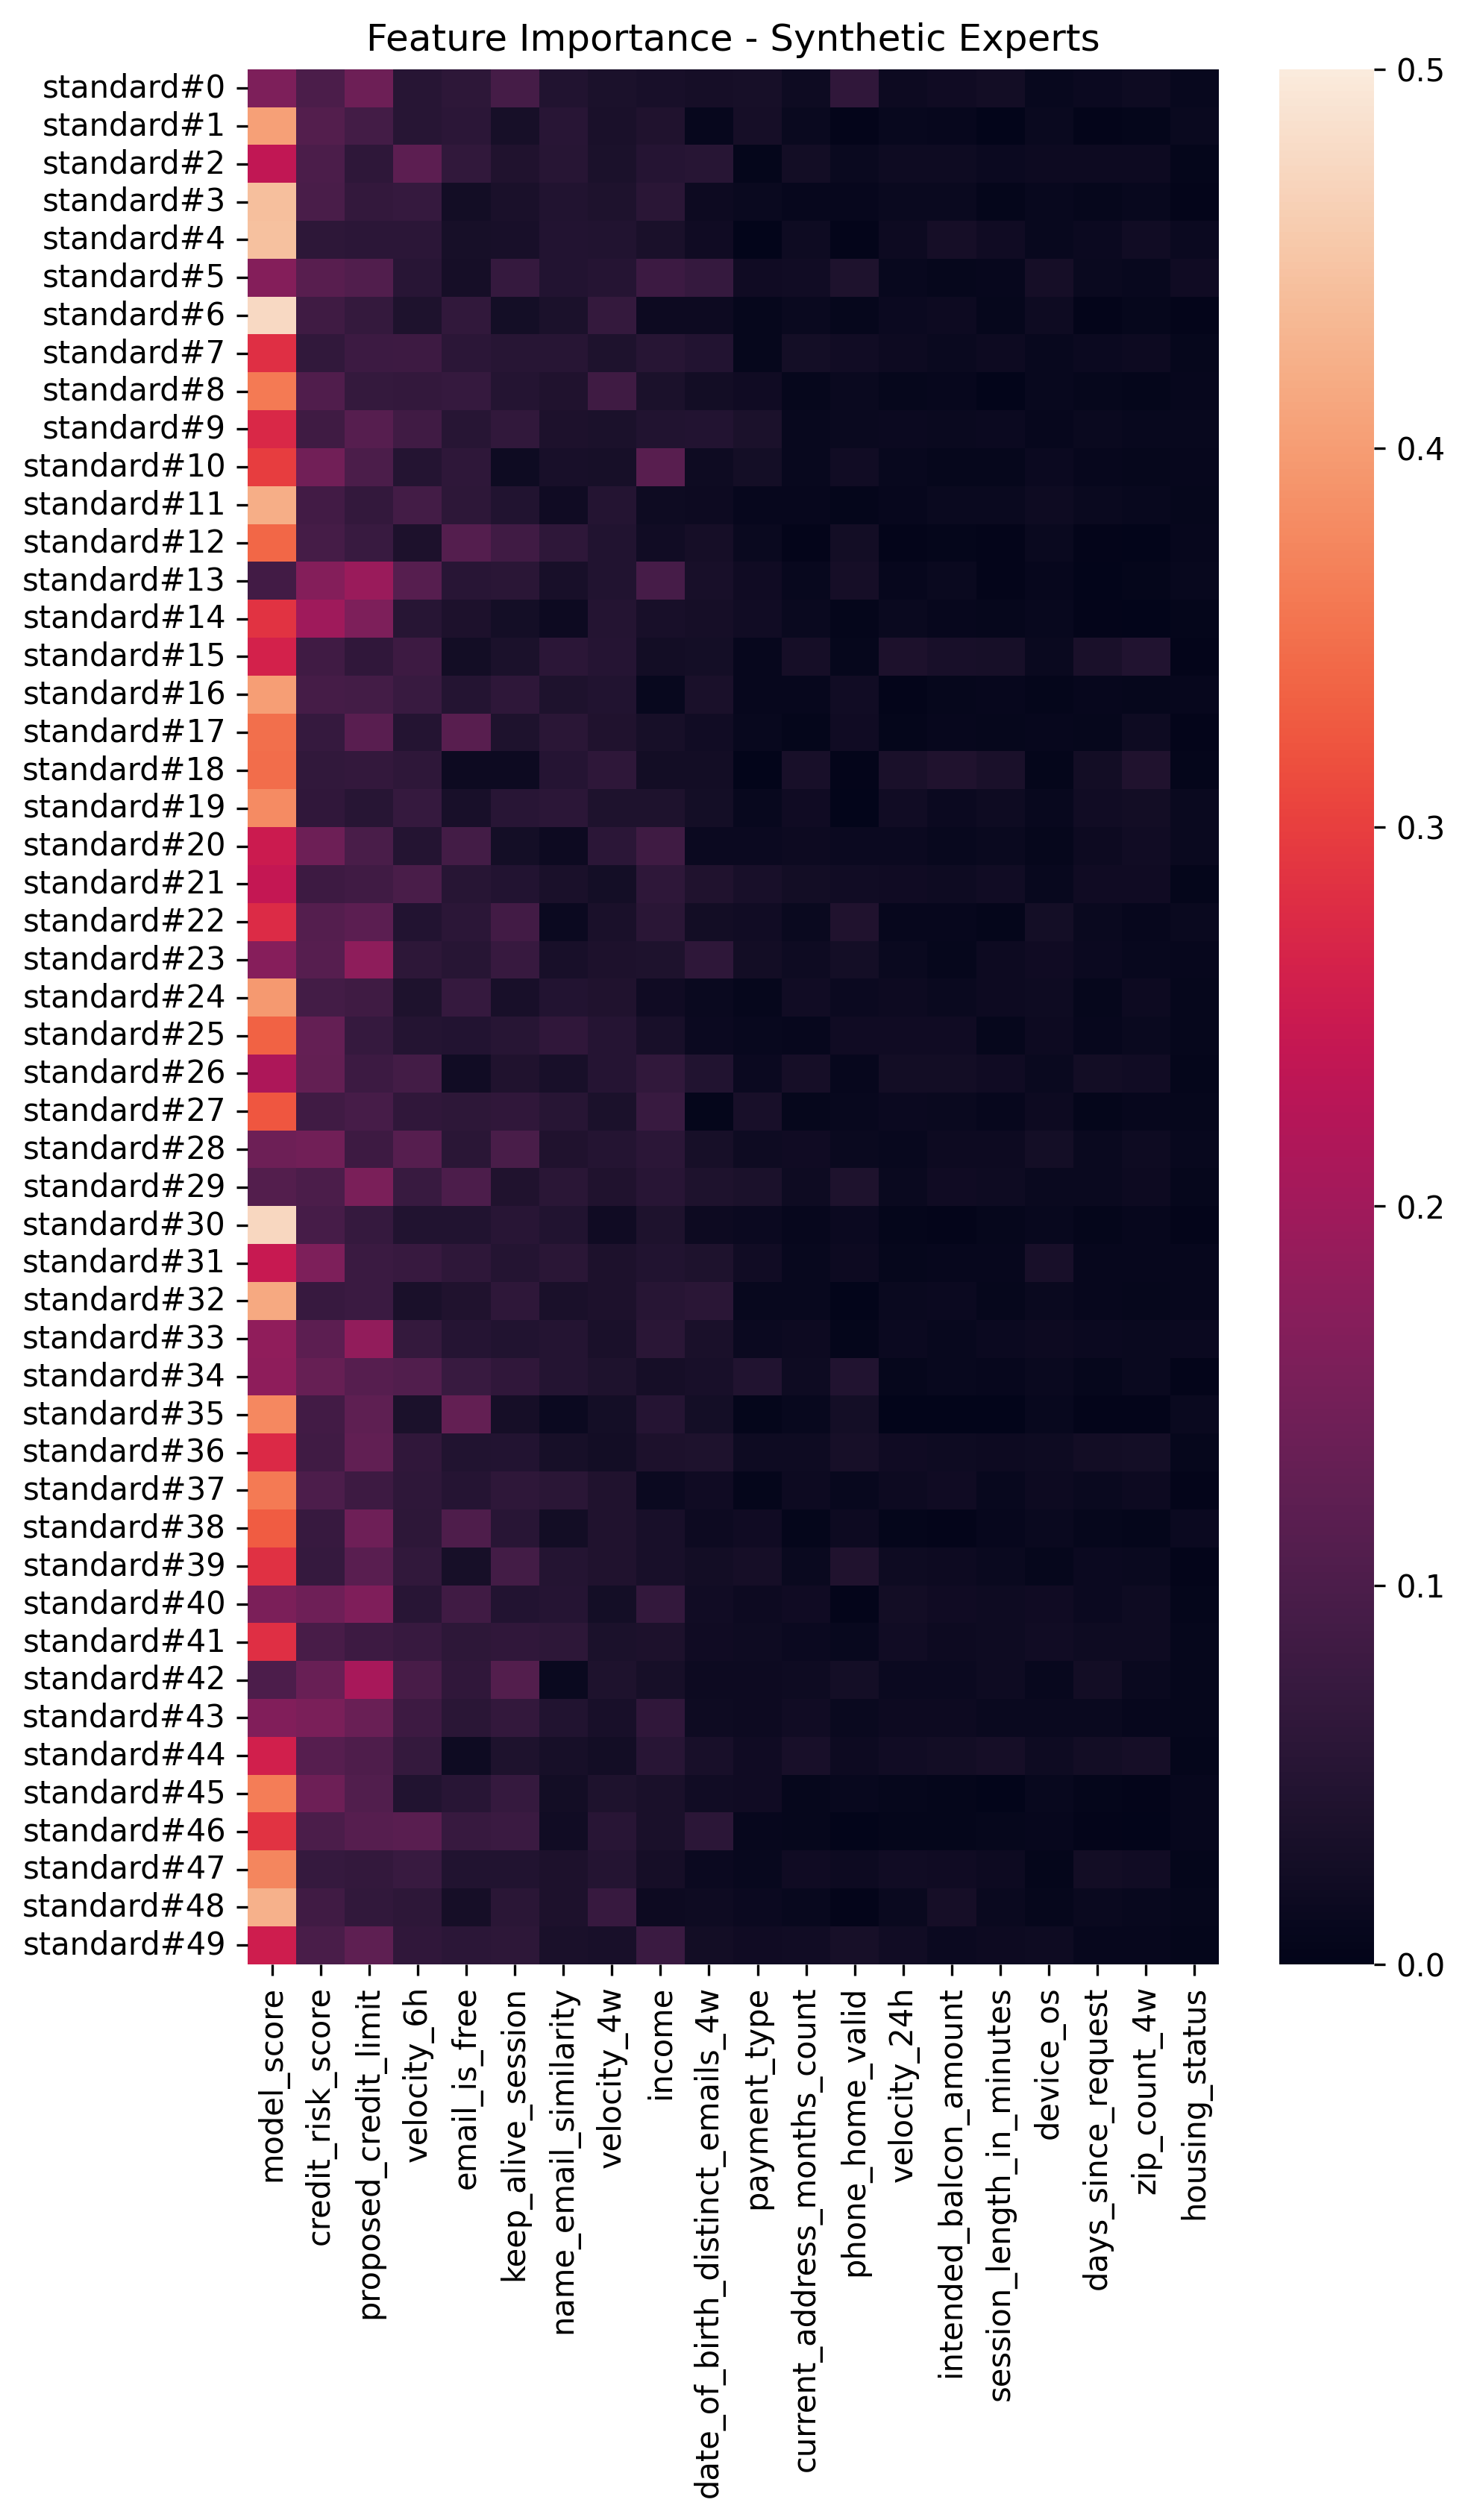

In [81]:
f, ax = plt.subplots(figsize=(7, 11), dpi = 300)
sns.heatmap(a.astype(float), vmin = 0, vmax = 0.5)
plt.title('Feature Importance - Synthetic Experts')
plt.savefig("Images/figure_16.pdf", format="pdf", bbox_inches="tight")

In [82]:
data = pd.read_parquet(f'../../FiFAR/alert_data/processed_data/alerts.parquet')
preds = pd.read_parquet(f'../../FiFAR/synthetic_experts/expert_predictions.parquet').loc[data.index]


metrics = pd.DataFrame(index = preds.columns, columns = ['fpr_disparity', 'Biased Against','TPR','FNR','FPR','TNR','Cost'])
old_ix  = data.loc[data['customer_age']>=50].index
yng_ix  = data.loc[data['customer_age']<50].index

for expert in preds.columns:
    tn, fp, fn, tp = confusion_matrix(y_pred = preds.loc[old_ix,expert], y_true = data.loc[old_ix,'fraud_bool']).ravel()
    old_fpr = fp/(fp+tn)
    tn, fp, fn, tp = confusion_matrix(y_pred = preds.loc[yng_ix,expert], y_true = data.loc[yng_ix,'fraud_bool']).ravel()
    yng_fpr = fp/(fp+tn)
    tn, fp, fn, tp = confusion_matrix(y_pred = preds[expert], y_true = data['fraud_bool']).ravel()

    if yng_fpr < old_fpr:
        metrics.loc[expert,'Biased Against'] = 'Older'
    else:
        metrics.loc[expert, 'Biased Against'] = 'Younger'
        
    metrics.loc[expert,'Predictive Equality'] = min(yng_fpr,old_fpr)/max(yng_fpr,old_fpr)
    metrics.loc[expert,'TPR'] = tp/(tp+fn)
    metrics.loc[expert,'FPR'] = fp/(fp+tn)
    metrics.loc[expert,'TNR'] = tn/(tn+fp)
    metrics.loc[expert,'FNR'] = fn/(fn+tp)
    metrics.loc[expert,'Cost'] = (fn + fp*0.057)/(fn+fp+tn+tp)


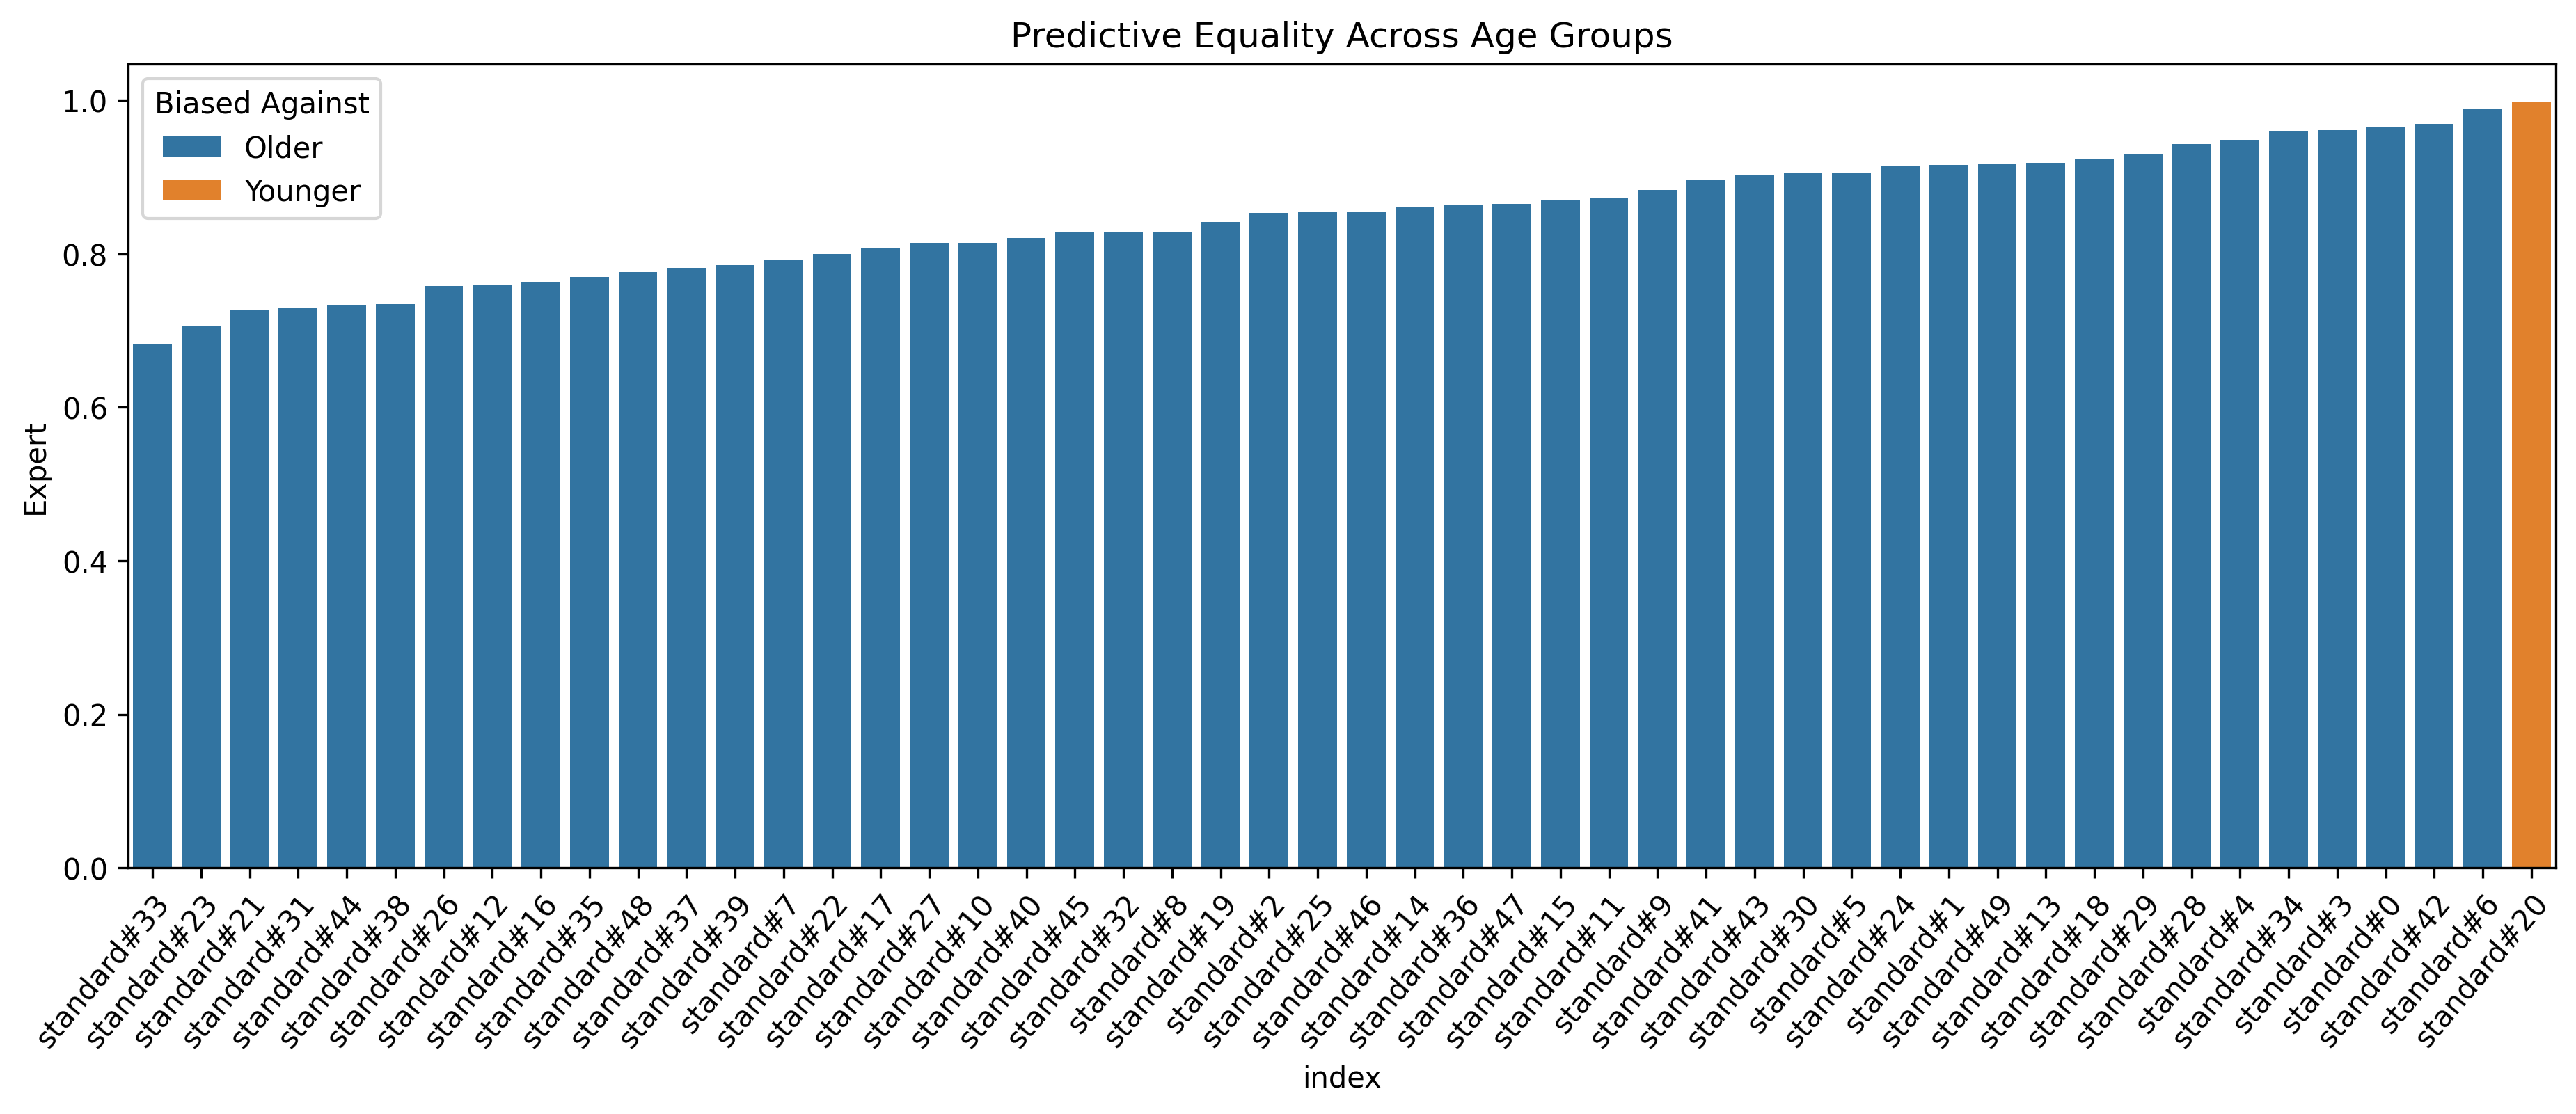

In [83]:
f, ax = plt.subplots(figsize=(15, 5), dpi = 300)
sns.barplot(data = metrics.reset_index().sort_values('Predictive Equality'),x = 'index', y = 'Predictive Equality', hue = 'Biased Against', dodge = False)
plt.ylabel('Expert')
plt.title('Predictive Equality Across Age Groups')
plt.xticks(rotation = 50, rotation_mode = 'anchor', ha = 'right')
plt.savefig("./Images/figure_11.pdf", format="pdf", bbox_inches="tight")

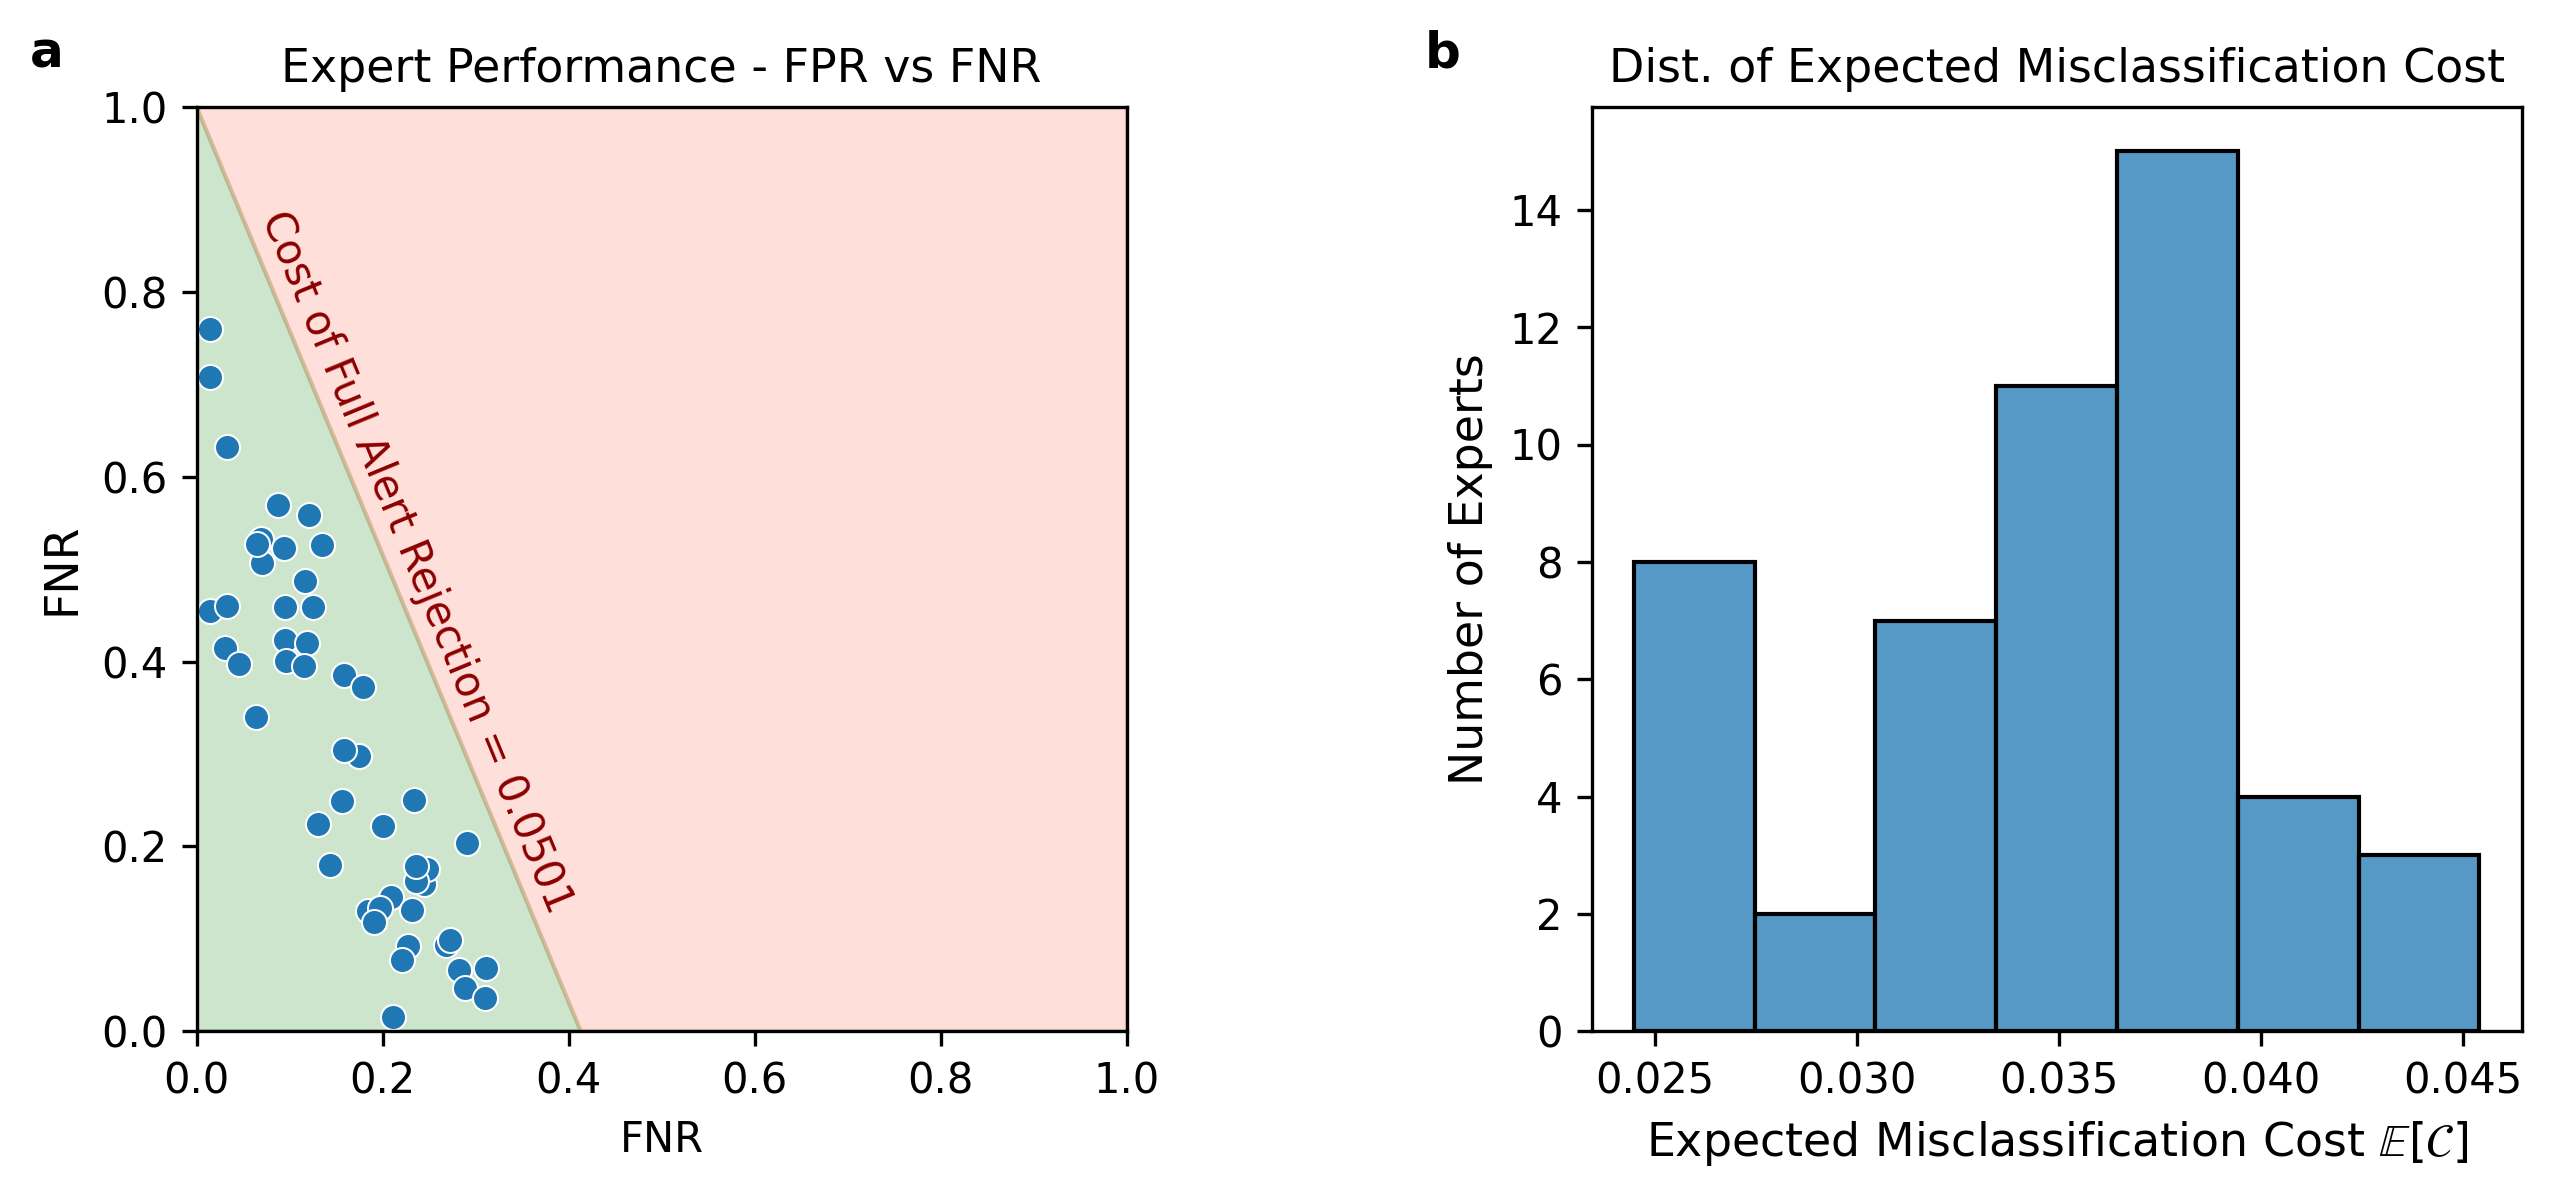

In [ ]:
f, ax = plt.subplots(figsize=(10, 4), dpi = 300, ncols = 2)
f.subplots_adjust(wspace = 0.5)
from matplotlib.transforms import ScaledTranslation

tn, fp, fn, tp = confusion_matrix(y_pred = np.ones(len(data['fraud_bool'])), y_true = data['fraud_bool']).ravel()
l = 0.057
prev = data['fraud_bool'].mean()
cost = (fn+fp*0.057)/(tp+tn+fp+fn)
slope = -(prev)/(l*(1-prev))
b = cost/(l*(1-prev))
ax[0].text(np.arange(0,1,0.001)[70], np.arange(0,1,0.001)[70]*slope + b + 0.05, f'Cost of Full Alert Rejection = {cost:.4f}', color = 'darkred', rotation = 360*np.arctan(slope)/(2*np.pi), rotation_mode = 'anchor', fontsize = 10)
ax[0].fill_between(x=np.arange(0,1.001,0.001),y1 = np.arange(0,1.001,0.001)*slope + b, alpha = 0.2, color = 'green')
ax[0].fill_between(x=np.arange(0,1.001,0.001),y1 = np.arange(0,1.001,0.001)*slope + b, y2 = np.ones(len(np.arange(0,1.001,0.001))), alpha = 0.2, color = 'tomato')
sns.scatterplot(ax = ax[0], data = metrics.reset_index(), x = 'FNR', y = 'FPR')
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].set_title('Expert Performance - FPR vs FNR', fontsize = 11)
ax[0].set_ylabel("FPR", fontsize = 11)
ax[0].set_ylabel("FNR", fontsize = 11)


sns.histplot(ax = ax[1], x = metrics['Cost'])
ax[1].set_xlabel(r"Expected Misclassification Cost $\mathbb{E}[\mathcal{C}]$", fontsize = 11)
ax[1].set_ylabel("Number of Experts", fontsize = 11)
ax[1].set_title(r"Dist. of Expected Misclassification Cost", fontsize = 11)





labels = ['a','b']
for a, label in zip(ax, labels):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    a.text(
        0.0, 1.0, label, transform=(
            a.transAxes + ScaledTranslation(-40/72, +7/72, f.dpi_scale_trans)), fontsize = 12, va='bottom', weight = 'bold')
    


plt.savefig("./Images/figure_10.pdf", format="pdf", bbox_inches="tight")

In [85]:
prop = pd.read_parquet(f'../../FiFAR/synthetic_experts/expert_parameters.parquet')
p_error = pd.read_parquet(f'../../FiFAR/synthetic_experts/prob_of_error.parquet').loc[data.index]
preds = pd.read_parquet(f'../../FiFAR/synthetic_experts/expert_predictions.parquet').loc[data.index]
p = pd.DataFrame()
def invert_labels_with_probabilities(labels_arr, p_arr, seed):
    rng = np.random.default_rng(seed=seed)
    mask = rng.binomial(n=1, p=p_arr).astype(bool)

    new_labels = labels_arr.copy()
    new_labels[mask] = np.abs(new_labels[mask] - 1)  # inverts labels

    return new_labels
for expert in preds.columns:
    p[expert] = p_error.loc[data.index,'p_fp_' + expert] + p_error.loc[data.index,'p_fn_' + expert]

d = dict()
for expert in preds.columns:
    temp = []
    for i in range(10):
        temp.append(invert_labels_with_probabilities(
                    labels_arr=data['fraud_bool'],
                    p_arr=p[expert],
                    seed= i))
    d[expert] = temp

k = dict()
count = 0
for expert in preds.columns:
    temp = []
    for i in range(10):
        for j in range(10):
            if i == j:
                continue
            elif i>j:
                continue

            temp.append(cohen_kappa_score(d[expert][i],d[expert][j]))
            count+=1
    
    k[expert] = temp

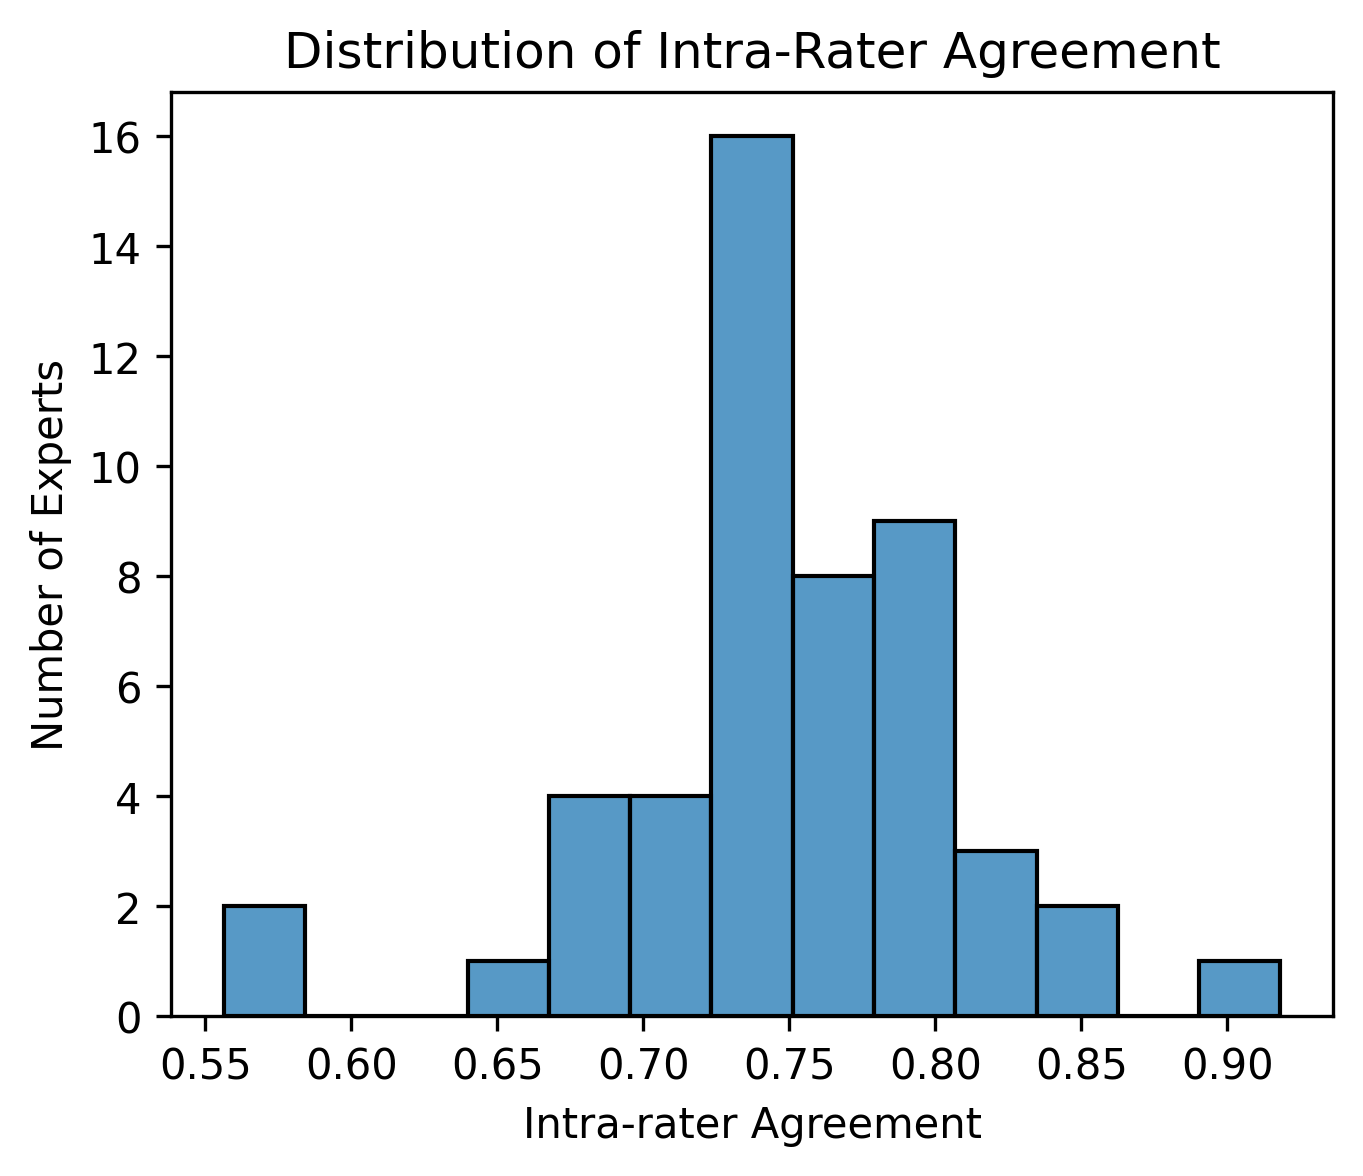

In [86]:
df = pd.DataFrame(k)
ck = df.melt().copy()
ck['alpha'] = ck.apply(lambda x: prop.loc[x['variable'],'alpha'], axis = 1)
f, ax = plt.subplots(figsize=(5, 4), dpi = 300)
sns.histplot(x = ck.groupby('variable').mean()['value'])
plt.xlabel("Intra-rater Agreement")
plt.ylabel("Number of Experts")
plt.title("Distribution of Intra-Rater Agreement")
plt.savefig("./Images/figure_6.pdf", format="pdf", bbox_inches="tight")


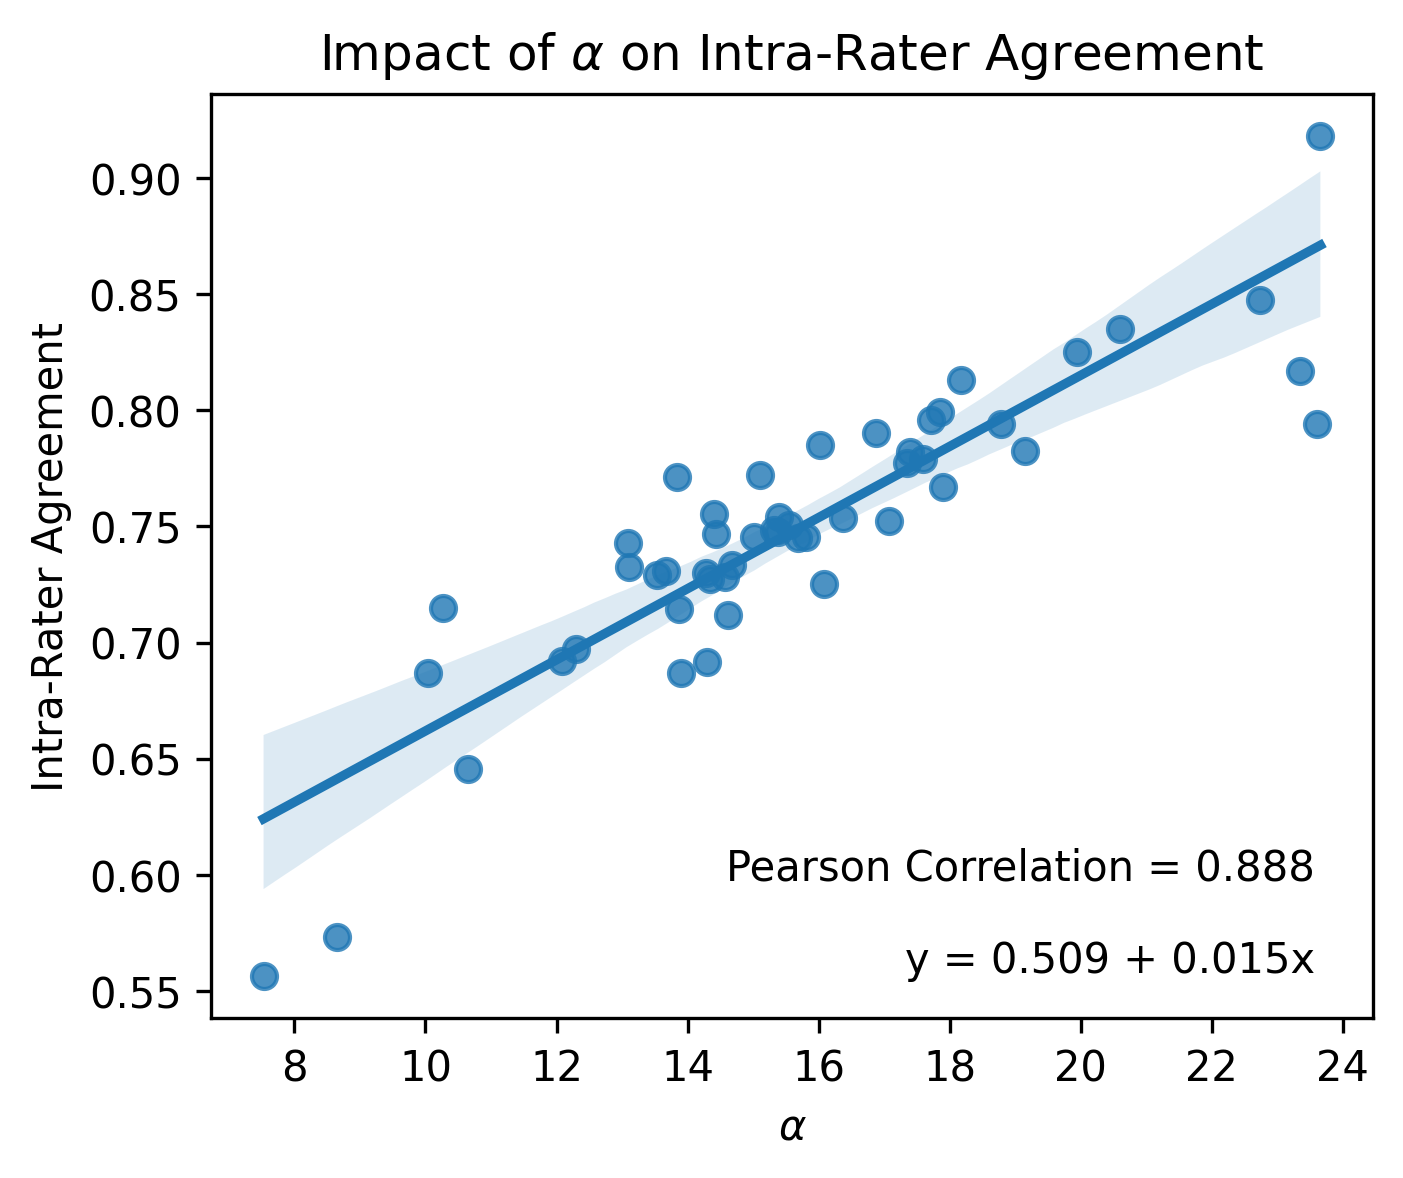

In [87]:

f, ax = plt.subplots(figsize=(5, 4), dpi = 300)
p = sns.regplot(data = ck.groupby('variable').mean(), x = 'alpha', y = 'value')
#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

#add regression equation to plot
plt.text(ax.get_xlim()[0] + 0.95*(ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[0] + 0.05*(ax.get_ylim()[1] - ax.get_ylim()[0]), 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x', horizontalalignment = 'right')
plt.text(ax.get_xlim()[0] + 0.95*(ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_ylim()[0] + 0.15*(ax.get_ylim()[1] - ax.get_ylim()[0]), 'Pearson Correlation = ' 
         + str(round(np.corrcoef(ck.groupby('variable').mean()['value'], ck.groupby('variable').mean()['alpha'])[0][1],3)),
         horizontalalignment = 'right')

plt.xlabel(r"$\alpha$")
plt.ylabel("Intra-Rater Agreement")
plt.title(r"Impact of $\alpha$ on Intra-Rater Agreement")
plt.savefig("./Images/figure_5.pdf", format="pdf", bbox_inches="tight")

In [88]:

CK = pd.DataFrame(index = preds.columns, columns = preds.columns)

for expert1 in CK.columns:
    for expert2 in CK.columns:
        if expert1==expert2:
            CK.loc[expert1,expert2] = 1
            continue
        if not np.isnan(CK.loc[expert1,expert2]):
            continue
        CK.loc[expert1,expert2] = cohen_kappa_score(preds[expert1],preds[expert2])
        CK.loc[expert2,expert1] = CK.loc[expert1,expert2]

temp = []
for expert1 in CK.columns:
    for expert2 in CK.columns:
        if expert1==expert2:
            break
        else:
            temp.append(CK.loc[expert1,expert2])

print(f'Minimum: {np.min(temp)}, Maximum: {np.max(temp)}, Mean: {np.mean(temp)}')

ck = temp

PA = pd.DataFrame(index = preds.columns, columns = preds.columns)
for expert1 in PA.columns:
    for expert2 in PA.columns:
        if expert1==expert2:
            PA.loc[expert1,expert2] = 1
            continue
        if not np.isnan(PA.loc[expert1,expert2]):
            continue
        PA.loc[expert1,expert2] = (preds[expert1] == preds[expert2]).astype(int).mean()
        PA.loc[expert2,expert1] = PA.loc[expert1,expert2]

temp = []
for expert1 in PA.columns:
    for expert2 in PA.columns:
        if expert1==expert2:
            break
        else:
            temp.append(PA.loc[expert1,expert2])

print(f'Minimum: {np.min(temp)}, Maximum: {np.max(temp)}, Mean: {np.mean(temp)}')

Minimum: 0.06397109083569863, Maximum: 0.791146226296935, Mean: 0.49266888578658957
Minimum: 0.3218927568414865, Maximum: 0.9529096727842727, Mean: 0.751716293074607


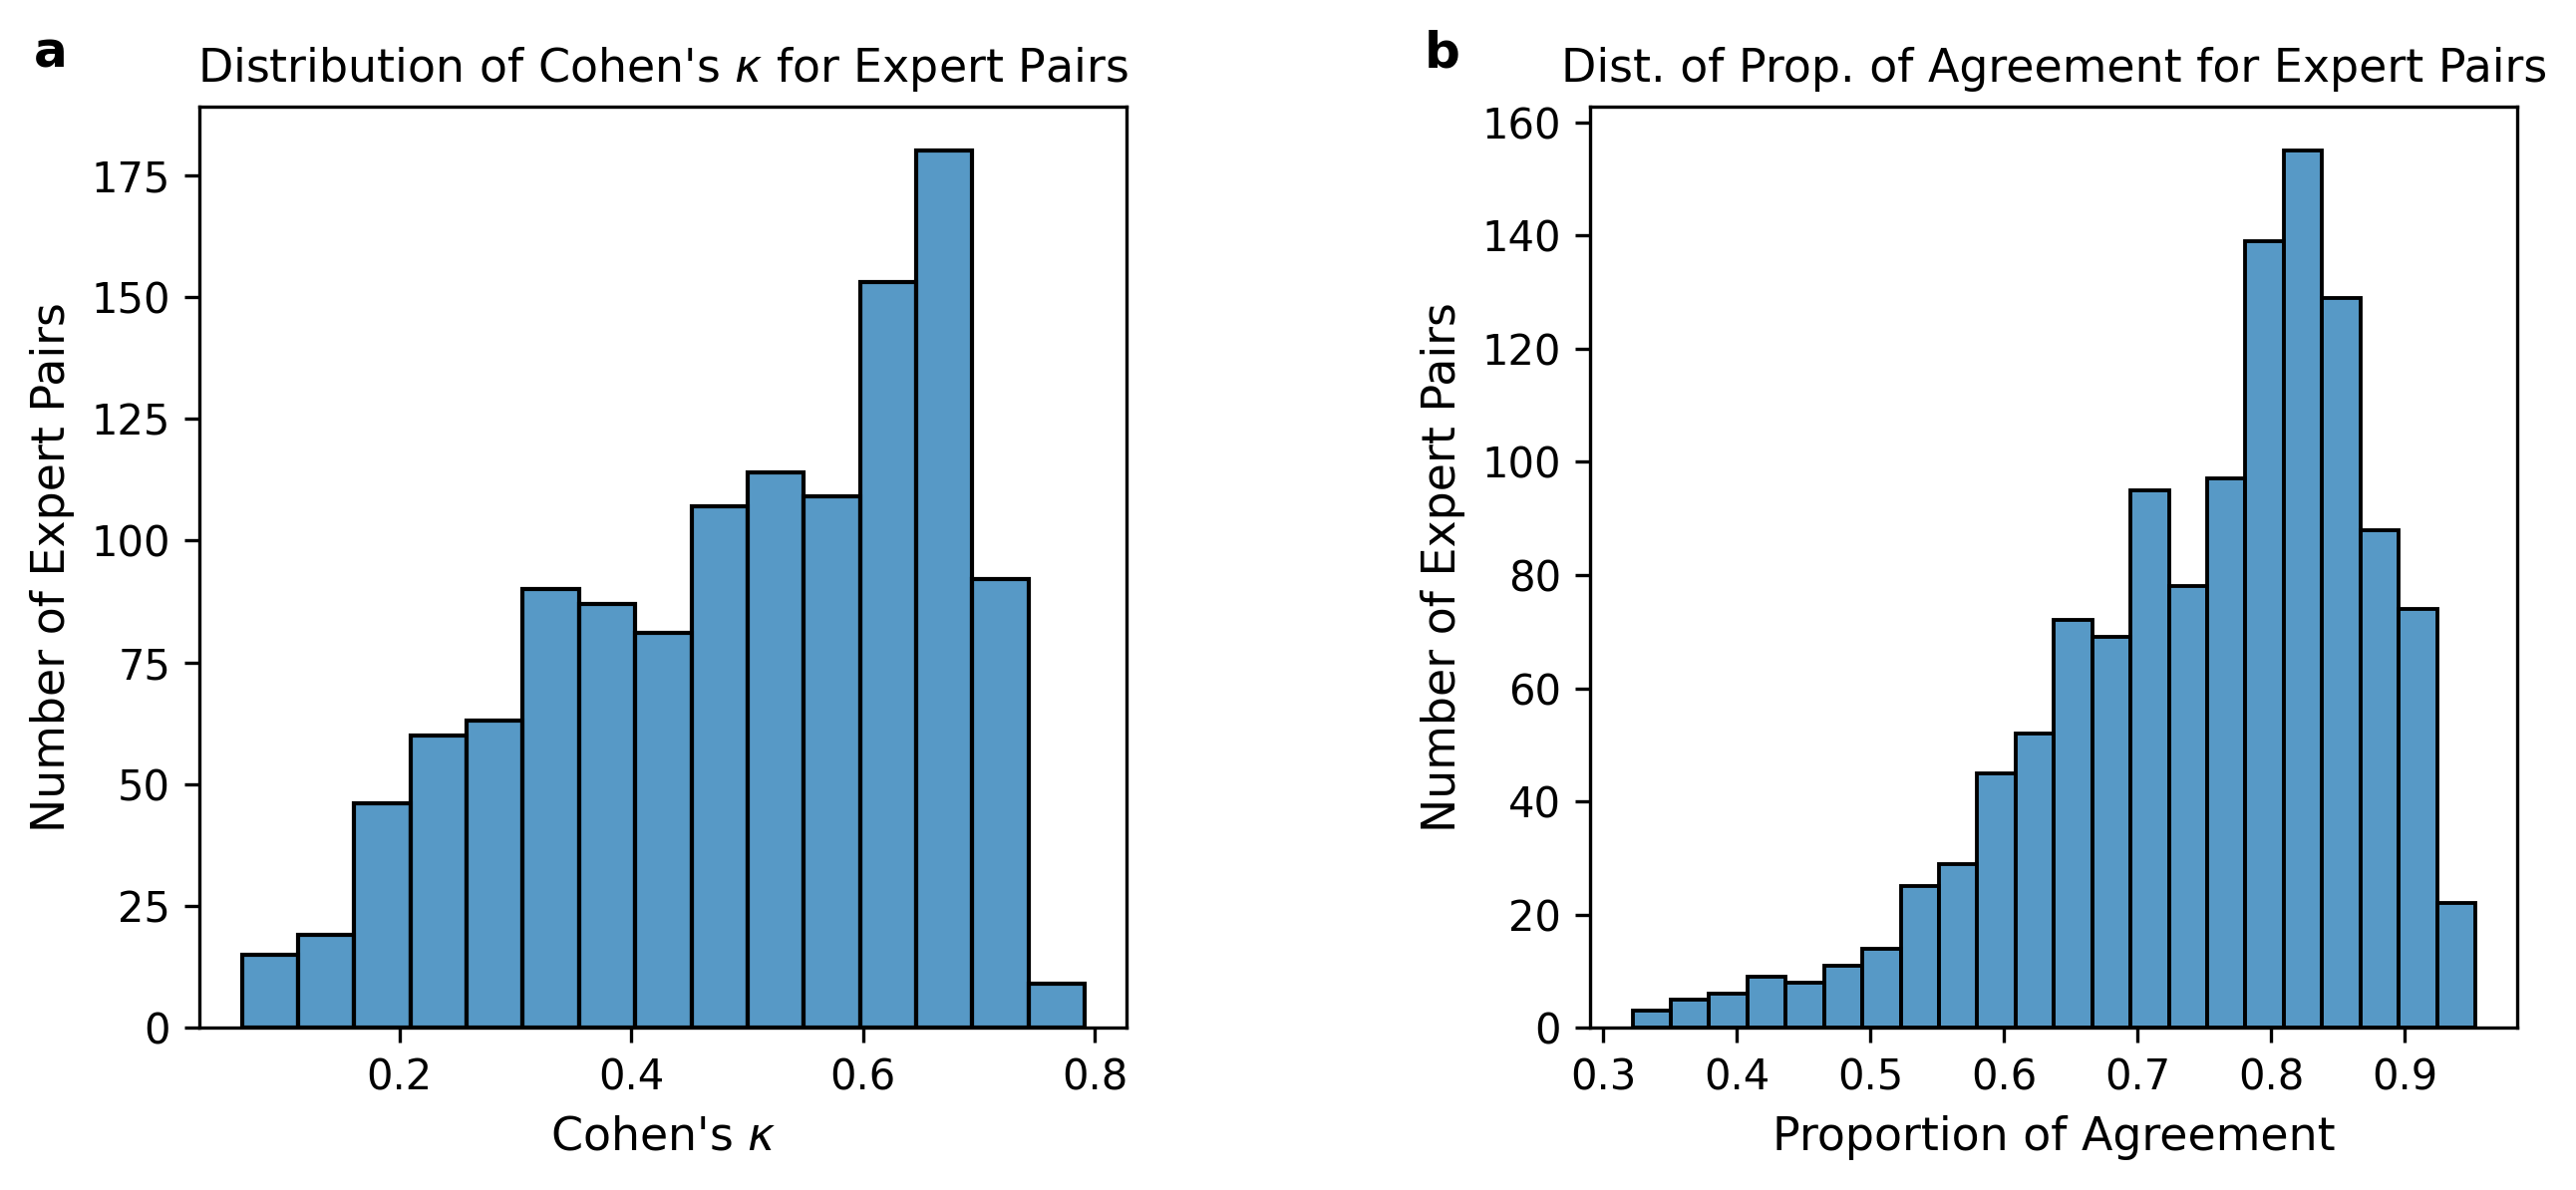

In [ ]:
f, ax = plt.subplots(figsize=(10, 4), dpi = 300, ncols = 2)
f.subplots_adjust(wspace = 0.5)

sns.histplot(ax = ax[0], x = ck)
ax[0].set_xlabel(r"Cohen's $\kappa$", fontsize = 11)
ax[0].set_ylabel("Number of Expert Pairs", fontsize = 11)
ax[0].set_title(r"Distribution of Cohen's $\kappa$ for Expert Pairs", fontsize = 11)

sns.histplot(ax = ax[1], x = temp)
ax[1].set_xlabel(r"Proportion of Agreement", fontsize = 11)
ax[1].set_ylabel("Number of Expert Pairs", fontsize = 11)
ax[1].set_title(r"Dist. of Prop. of Agreement for Expert Pairs", fontsize = 11)

labels = ['a','b']
for a, label in zip(ax, labels):
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    a.text(
        0.0, 1.0, label, transform=(
            a.transAxes + ScaledTranslation(-40/72, +7/72, f.dpi_scale_trans)), fontsize = 12, va='bottom', weight = 'bold')
    


plt.savefig("./Images/figure_9.pdf", format="pdf", bbox_inches="tight")

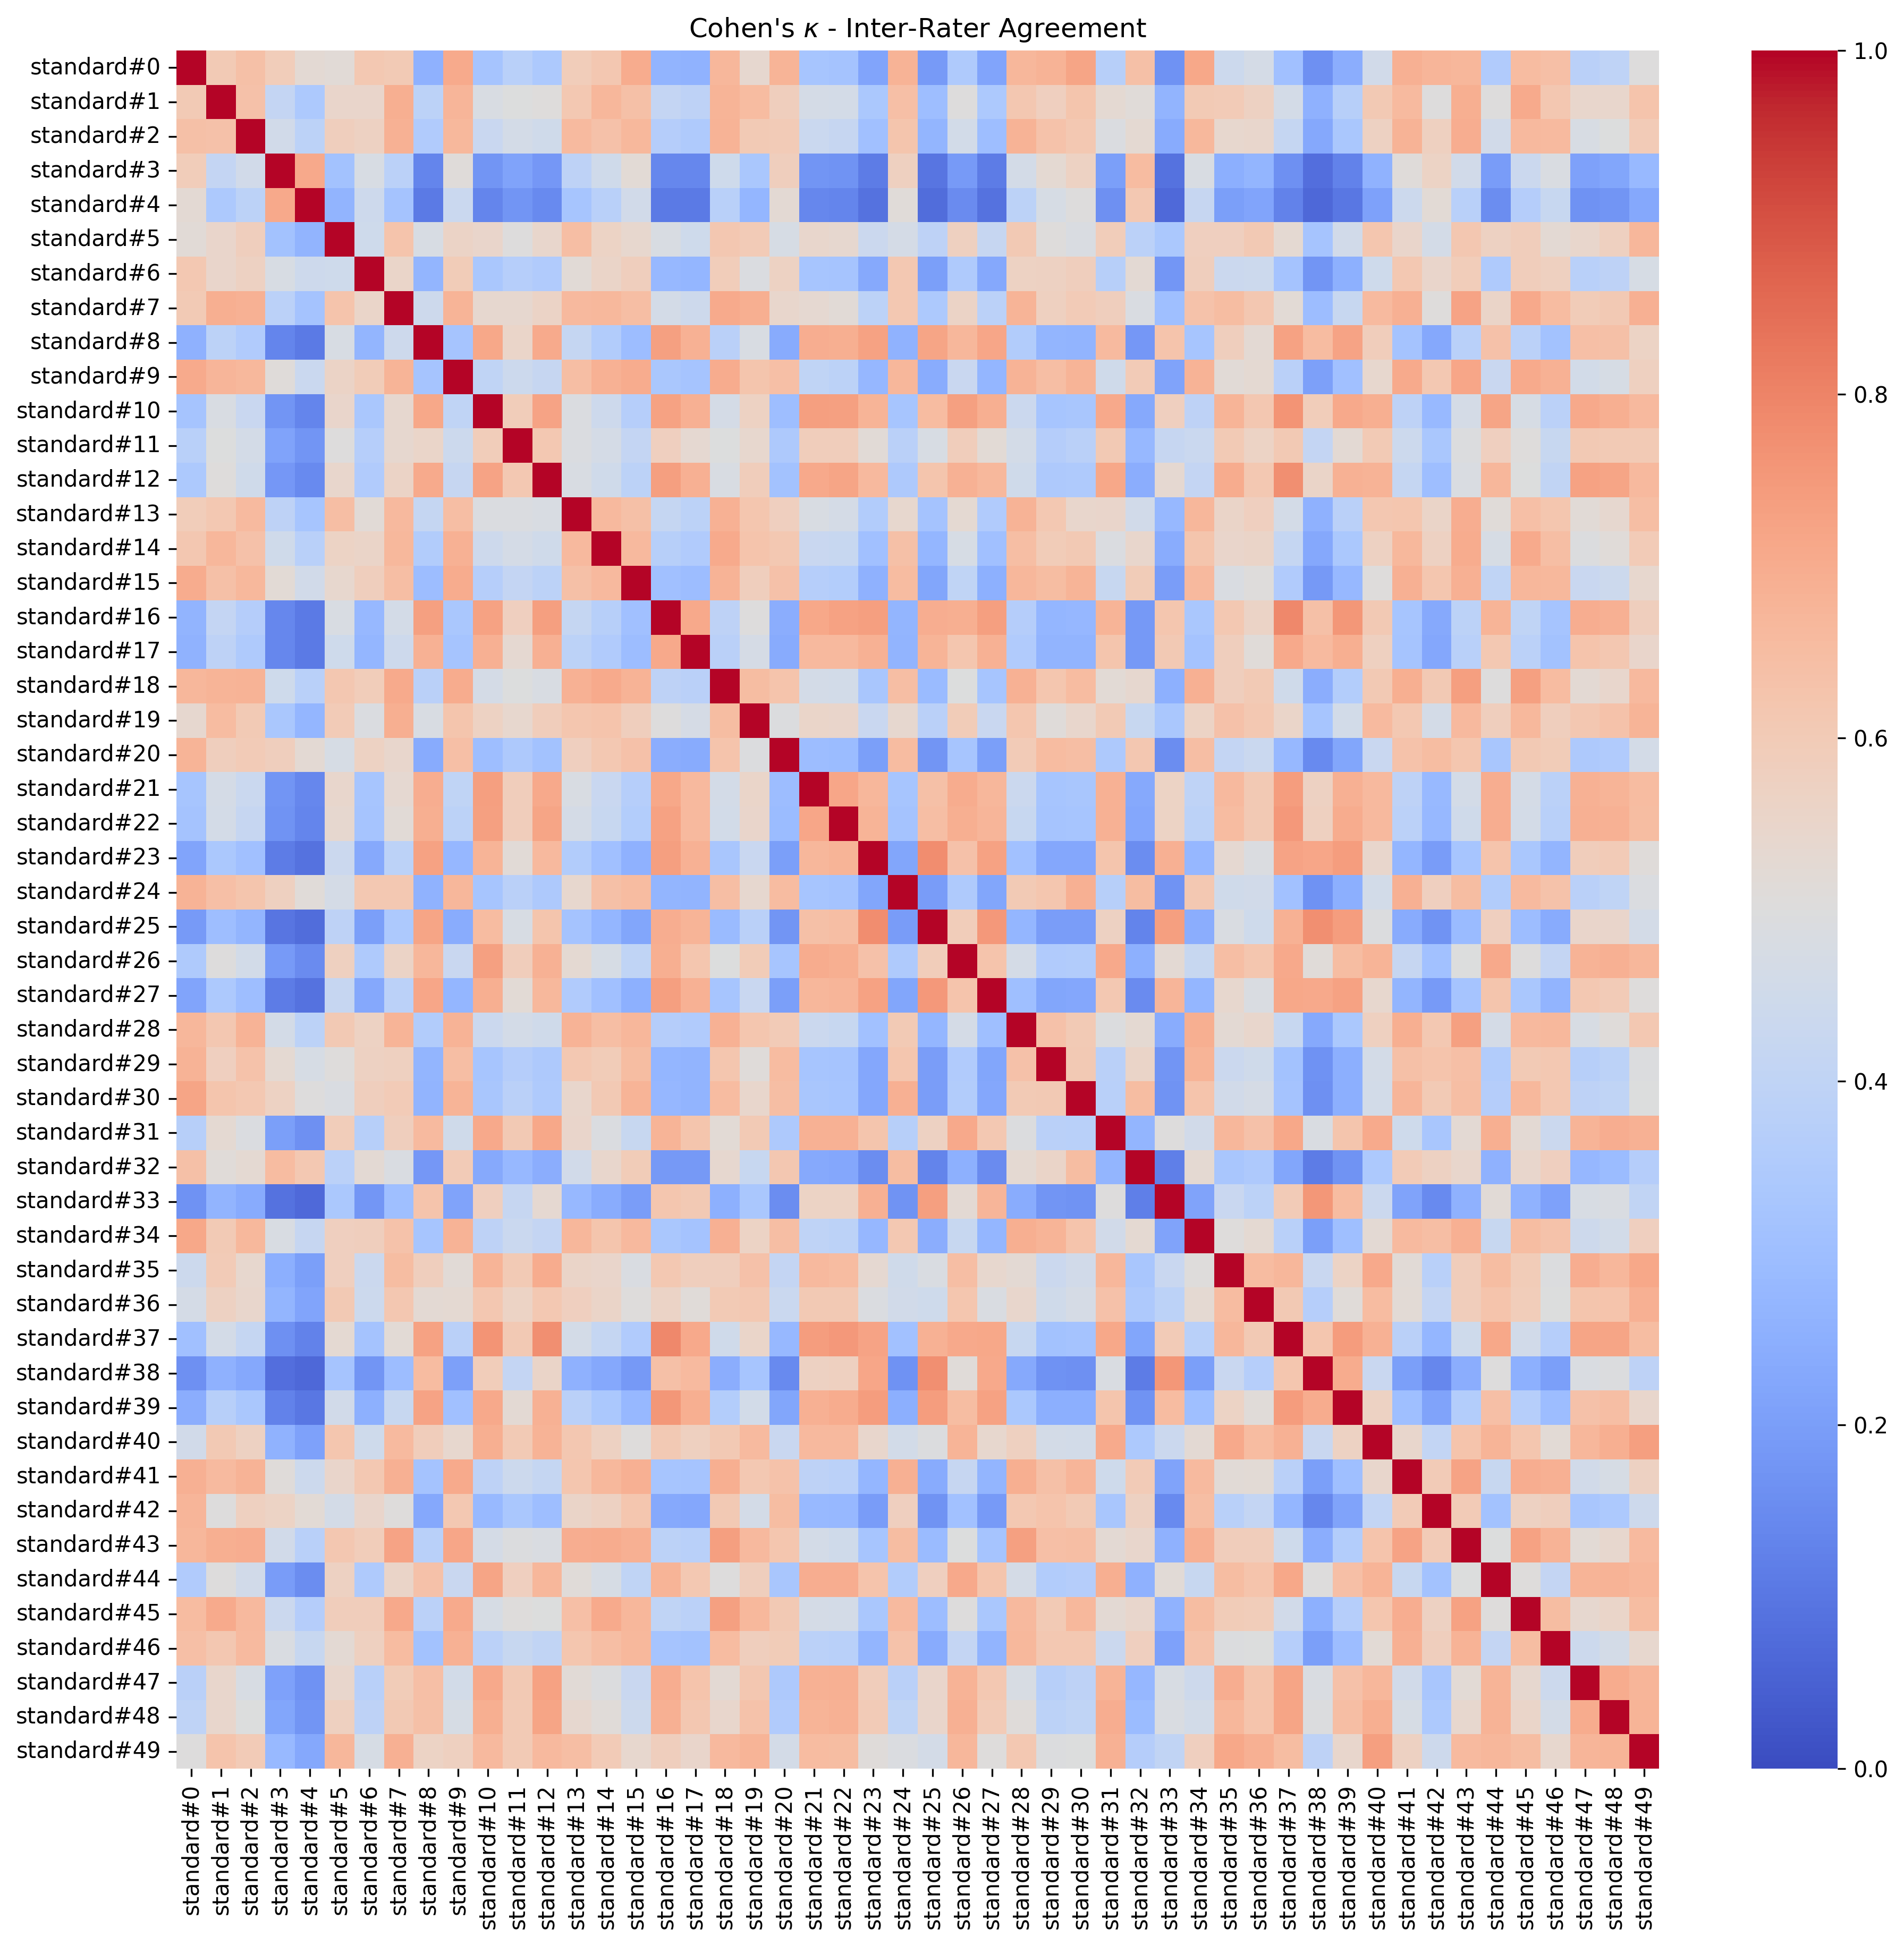

In [90]:
f, ax = plt.subplots(figsize=(15, 14), dpi = 300)
sns.heatmap(CK.astype(float), robust=True, cmap = 'coolwarm', vmax = 1, vmin = 0, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title(r"Cohen's $\kappa$ - Inter-Rater Agreement")
plt.savefig("./Images/figure_7.pdf", format="pdf", bbox_inches="tight")
plt.show()

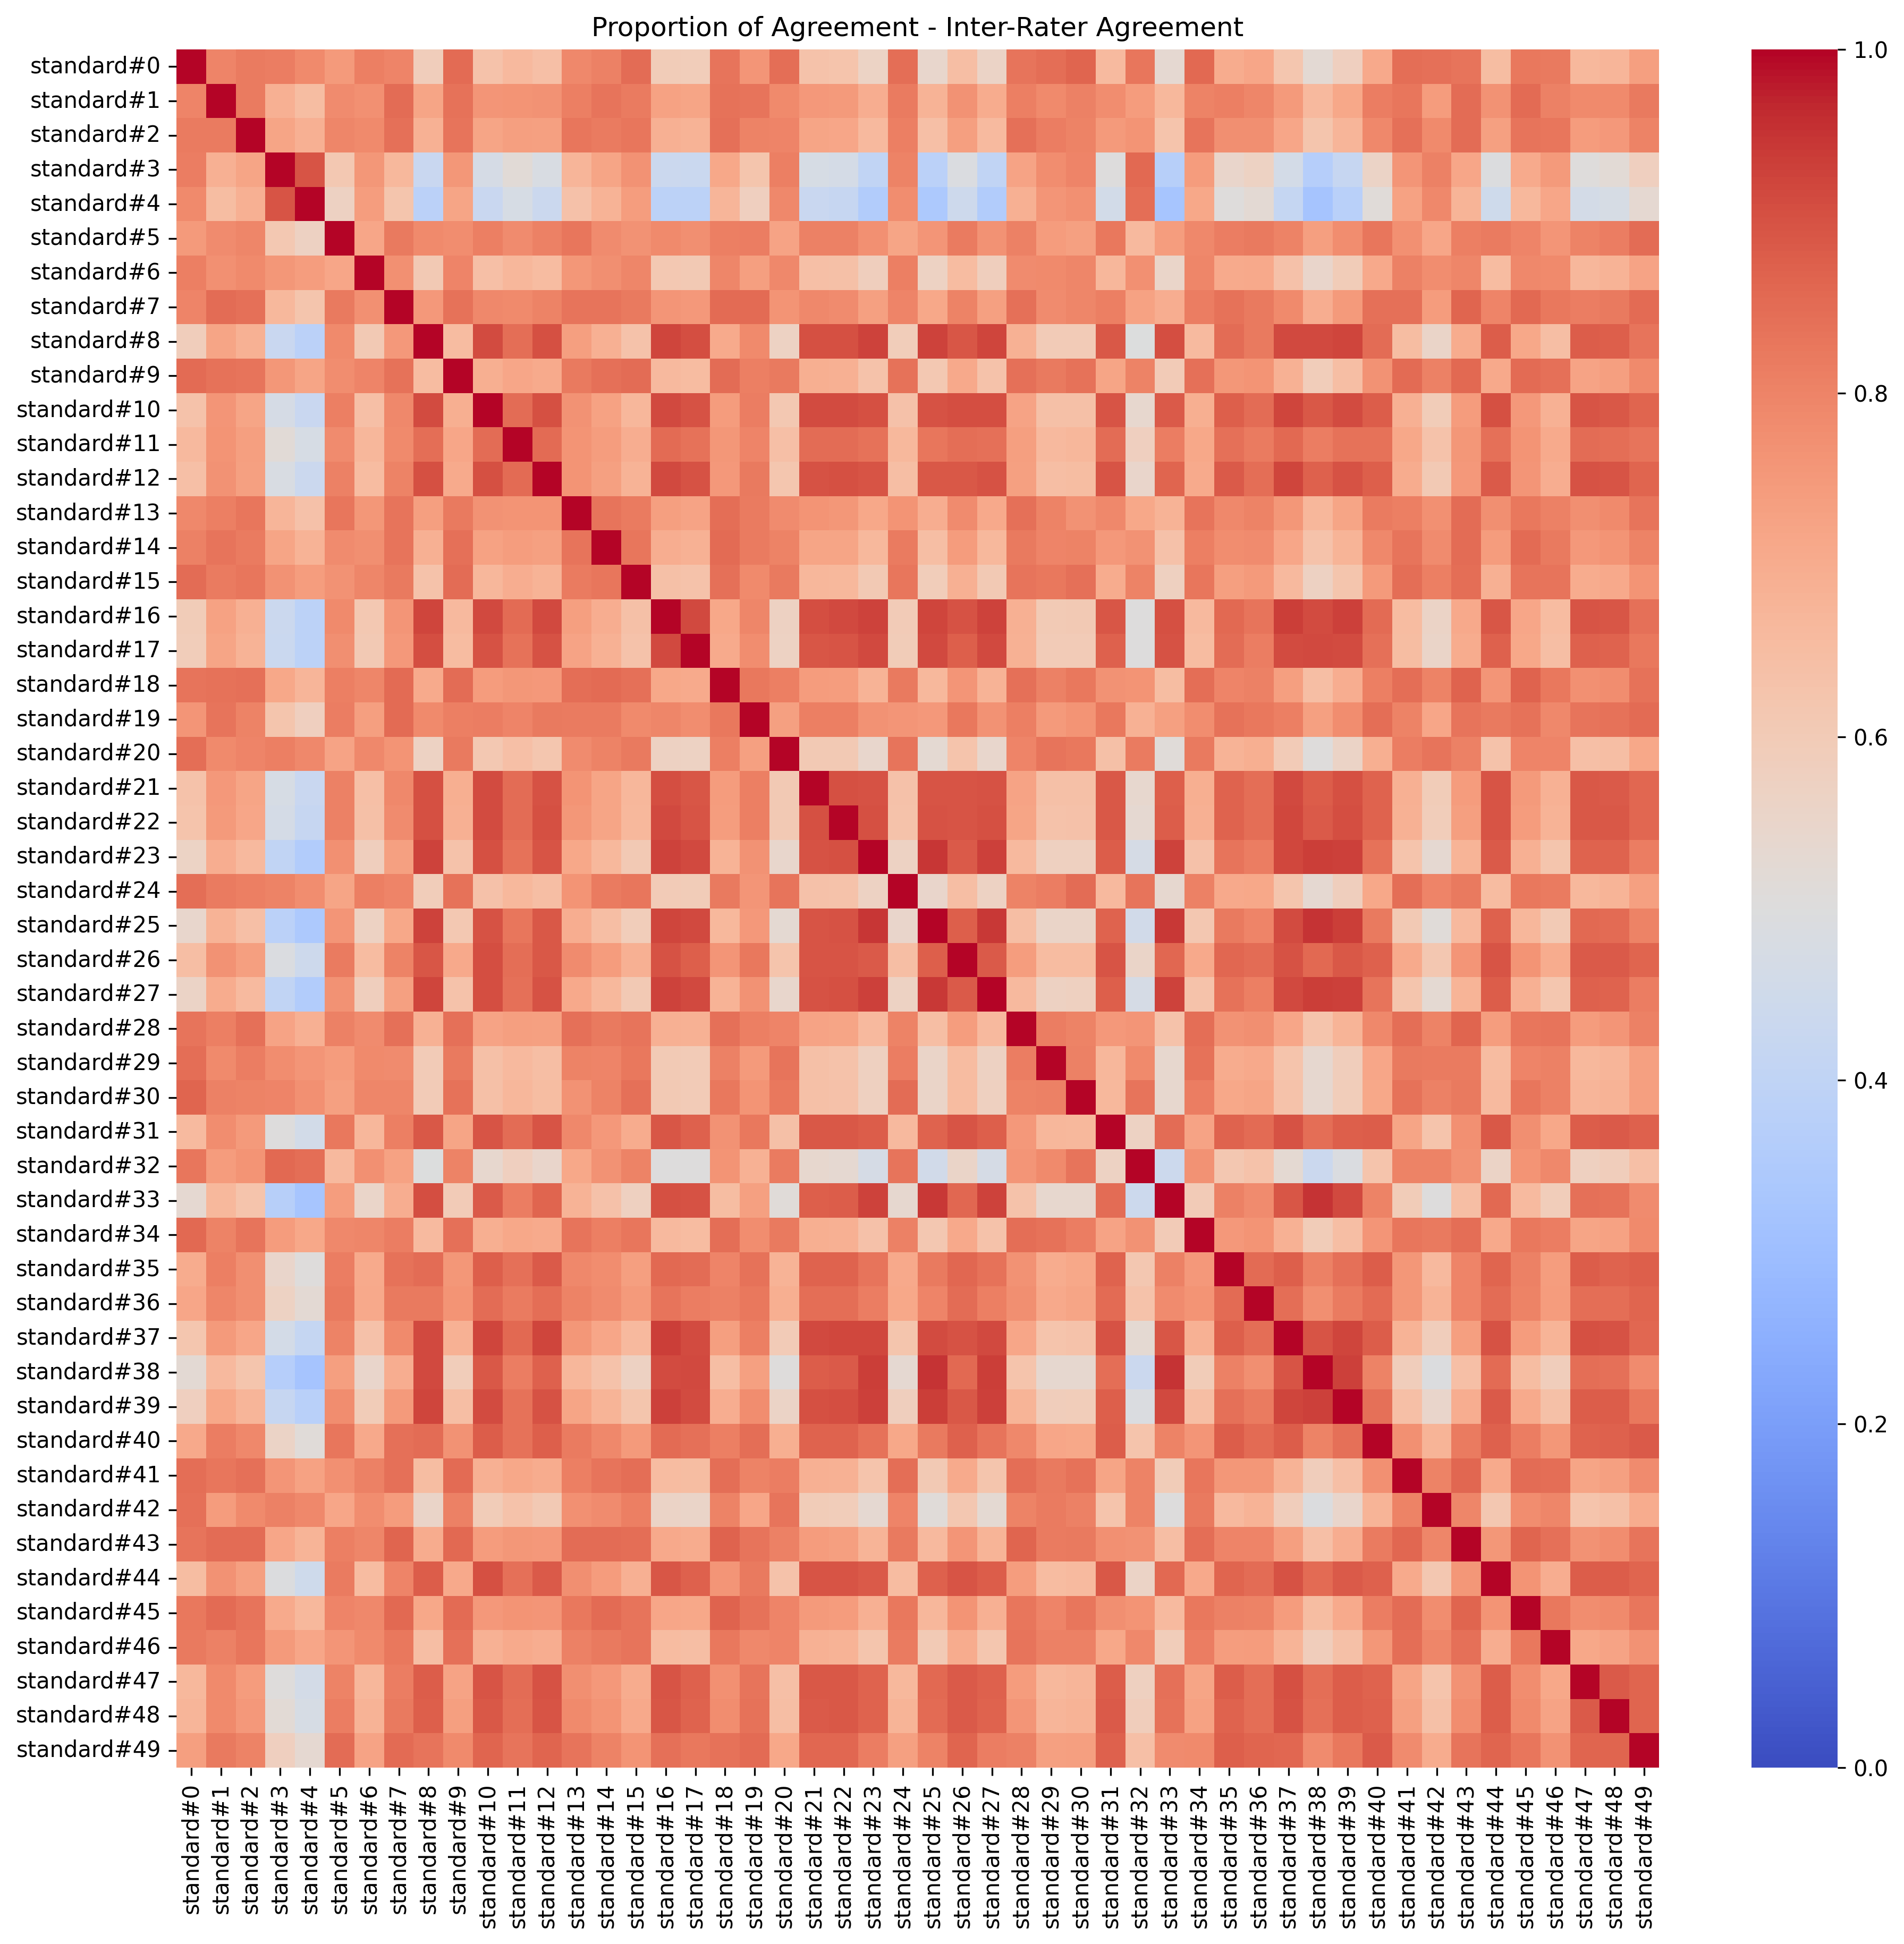

In [91]:
f, ax = plt.subplots(figsize=(15, 14), dpi = 300)
sns.heatmap(PA.astype(float), robust=True, cmap = 'coolwarm', vmax = 1, vmin = 0, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title(r"Proportion of Agreement - Inter-Rater Agreement")
plt.savefig("./Images/figure_8.pdf", format="pdf", bbox_inches="tight")
plt.show()